# Spark DataFrame

* Last updated 20201013TUE1400 20191029_20170606_20170221_20161125

## S.1 학습내용

### S.1.1 목표

* Spark DataFrame을 생성하고, API를 사용할 수 있다.
* Spark SQL을 사용하여 데이터를 조회할 수 있다.
* Spark 데이터를 MongoDB에 쓰고, 읽을 수 있다.

### S.1.2 목차
* S.2 Jupyter Notebook에서 SparkSession 생성
* S.3 DataFrame: 특징, Schema, DataFrame의 API
* S.4 DataFrame 생성
* S.4.1 schema에서 생성하기
* S.4.2 RDD에서 생성하기
* S.4.3 Pandas
* S.4.4 csv 파일 읽기
* S.4.5 tsv 파일 읽기
* S.4.6 JSON 파일 읽기
* 문제: 월드컵 데이터 JSON
* S.4.7 Parquet 파일 읽기, 쓰기
* S.5 DataFrame API 사용해 보기
    * 빈 DataFrame 생성
    * range
    * 컬럼 추가 withColumn, 컬럼 삭제 Drop
    * 사용자정의 함수 udf
    * 컬럼명 변경 withColumnRenamed
    * 그래프
    * 컬럼 조회 select
    * filter
    * regexp_replace 컬럼의 내용 변경
    * groupBy
    * F 함수
    * 행 추가
    * partition
    * 통계 요약 describe
    * 결측값
* 문제: 년별 분기별 대여건수
* S.6 Spark SQL
* 문제 S-1: 네트워크에 불법적으로 침입하는 사용자의 분석
* 문제 S-2: Twitter JSON 데이터 읽기
* 문제 S-3: 뉴욕에서 출생한 신생아 분석
* 문제 S-4: 우버 택시의 운행기록 분석
* 문제 S-5: JDBC를 사용해서 데이터 읽기
* S.7 MongoDB Spark connector
* S.7.1 설정
* S.7.2 uri 
* S.7.3 MongoDB Python API 
* S.7.4 연습으로 쓰기, 읽기
* S.8 spark-submit
* S.8.1 간단한 작업
* S.8.2 MongoDB

## S.2 Jupyter Notebook에서 SparkSession 생성

### Spark를 설치한 경우

Spark를 설치했다면, Spark가 설치된 디렉토리를 SPARK_HOME으로 설정하고, 실행에 필요한 'py4j-0.10.1-src.zip', 'pyspark.zip' 라이브러리를 추가해야 한다.

In [1]:
import os
import sys
os.environ["SPARK_HOME"]=os.path.join(os.environ['HOME'],'Downloads','spark-2.0.0-bin-hadoop2.7')
os.environ["PYLIB"]=os.path.join(os.environ["SPARK_HOME"],'python','lib')

# 스파크 풀 버전을 설치한 경우가 없을 것임으로 프리빌더 어서 안해줘도 될 듯
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'py4j-0.10.1-src.zip'))
sys.path.insert(0,os.path.join(os.environ["PYLIB"],'pyspark.zip'))

그러나 pyspark만을 설치한 경우에는, 위와 같이 별도로 경로와 라이브러리를 추가하지 않아도 된다.
다만 Python 2, 3 여러 버전이 설치된 경우에는 아래와 같이 그 경로를 설정해 주어야 한다.

In [2]:
import os
os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"

In [1]:
import pyspark
myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [ ]:
print (spark.version)

## S.3 DataFrame

### 특징

DataFrame은 **행, 열로 구조화**된 데이터구조이다.
관계형데이터베이스 RDB의 테이블이나 엑셀 쉬트sheet와 비슷하다.
또는 Pandas 또는 R을 사용해 보았다면 거기서 제공되는 DataFrame과 유사하다.
Apache Spark 1.0에서는 **SchemaRDD**라는 명칭으로 시험적으로 제공되었다. 이름에서 보듯이 RDD에 스키마를 얹어서 만든 개념이다.
그러나 Spark의 DataFrame은 **대용량 데이터를 처리하기 위해 만들어진 프레임워크로 분산**해서 사용할 수 있게 고안되었다.

앞서 사용했던 **RDD가 schema를 정하지 않는** 것과 달리, **DataFrame은 모델 schema**를 설정해서 사용을 한다. '열'에 대해 명칭 및 **데이터 타잎**을 가지고 있고, 이를 지켜서 데이터를 저장하게 된다. 

### Schema

**Row**는 DataFrame의 행으로, 데이터 요소항목을 묶어서 구성한다. **Python list나 dict**를 사용하여 Row를 구성할 수 있다.
**Column**은 DataFrame의 **열**이고, 다음과 같은 **데이터 타잎**을 가진다.

```python
- NullType
- StringType
- BinaryType
- BooleanType
- DateType
- TimestampType
- DoubleType
- DecimalType
- ShortType
- ArrayType
- MapType
```

### DataFrame의 API

RDD와 마찬가지로 DataFrame을 구성하여 **머신러닝**의 입력데이터로 사용할 수 있다.
현재 버전 2.0부터 RDD에 대한 지원은 줄여나가고, **버전 3.0 이후에는 DataFrame API를 공식적으로 지원**한다고 발표한 바 있다. RDD보다 우선적으로 사용하는 것이 좋겠다. 아래는 DataFrame에서 제공하는 일부 API이다.

기능 | 설명 | 예제
-------|-------|-------
```json``` | json 파일에서 읽기 | ```spark.read.json("employee.json")```
```show``` | DataFrame에 로딩된 데이터 읽기 | ```df.show()```
```schema``` | 데이터 schema 보기 | ```df.printSchema()```
```select``` | 열을 선택 | ```df.select("name")```
```filter``` | 조건으로 선택하여 읽기 | ```df.filter(dfs("age") > 23).show()```
```groupBy``` | 그룹으로 나누기 | ```df.groupBy("age").count().show()```
```dropna``` | na를 삭제 | ```df.dropna()``` ```df.na.drop()```
```fillna``` | na를 값으로 채우기 | ```fillna()```
```count``` | 행 세기 | ```df.count()```
```drop``` | 삭제 | ```df.drop("name")```


## S.4 DataFrame 생성

DataFrame은 관계형데이터베이스 RDB 테이블과 같이, schema를 정해서 생성한다.
**schema를 정해주지 않으면, Spark가 자동으로 유추**하게 된다.
Python 리스트, RDD, Pandas DataFrame, Hive, csv, JSON, RDB, XML, Parquet, Apache Cassandra 등 다양한 채널에서 읽어서 DataFrame을 만들 수 있다.

* **```spark.createDataFrame()```** 함수는 Python List, RDD, Pandas DataFrame 등에서 읽어서 DataFrame을 만들 수 있다.
* 또는 **```spark.read.text, spark.read.json, spark.read.parquet, spark.read.load```** 함수로 옵션을 설정해서 외부 파일 등에서 읽을 수 있다.


### S.4.1 schema 생성하기

DataFrame은 데이터 모델 schema를 정의하고, 각 컬럼의 명칭과 데이터타입을 정해야 한다.

#### 자동으로 인식하는 schema

우선 단순하게 Python 자료구조를 사용해서 생성해 본다.
아래 열이 3개인 데이터를 **```createDataFrame()```** 함수를 사용하여 넣어 보자.

In [ ]:
# 튜플로 만듬
print(f"type: {type(('1','kim, js', 170))}")

myList=[('1','kim, js', 170),
        ('1','lee, sm', 175),
        ('2','lim, yg',180),
        ('2','lee', 170)]

In [ ]:
# context 접근 안함
myDf=spark.createDataFrame(myList)

이 경우 Spark가 **자동으로 schema를 설정**한다.
```printSchema()``` 함수로 schema를 출력해 보기로 하자.
* **컬럼**명은 **일련번호**를 가지고 생성된다. schema를 정하지 않았으므로, 열은 '_1', '_2'와 같이 명명된다.
* **데이터 타잎**도 유추해서 생성한다. 올바르게 되지 않을 경우도 있다는 점에 유의한다. 아래에서 보듯이 컬럼 1 학년은 ```String```, 컬럼 2 이름은 ```String```, 컬럼 3 키는 ```long```으로 인식하고 있다.
* nullable은 결측값이 허용되는지를 말하는 것이다. true이면 허용된다는 의미이다.

In [ ]:
myDf.columns

In [ ]:
myDf.printSchema()

한 줄을 출력해 보자. 출력은 Row() 타입으로 앞서 정의한 schema와 일치하는 값을 포함하여 출력한다.
즉 첫째, 둘째는 문자열로 세째는 long 타입이다.

In [ ]:
print (myDf.take(1))

#### 컬럼명 설정

앞서 컬럼 Column을 정의하지 않고 DataFrame을 생성하였는데, 이번에는 **컬럼을 정해서** 생성하자.
**```createDataFrame()```** 함수에 **인자로 컬럼명을 리스트 ```['year','name','height']```로** 정해준다.

In [ ]:
cols = ['year','name','height']
_myDf = spark.createDataFrame(myList, cols)

In [ ]:
_myDf.columns

그리고 한 줄 출력해 보면, 컬럼명이 변경되어 있다.

In [ ]:
print (_myDf.take(1))

데이터 100개를 생성해 보자.
우선 데이터의 원천이 되는 names, items를 정의하자.
여기서 하나씩 선택하여 데이터를 생성하게 된다.

In [ ]:
names = ["kim","lee","lee","lim"]
# long black 아메리카노
items = ["espresso","latte","americano","affocato","long black","macciato"]

이 names, items 배열에서 **modulus**를 활용하여 하나씩 선택하여 데이터를 생성한다.
**names**는 4개이므로 4로 나눈 나머지와 **items**는 6개이므로 6으로 나눈 나머지를 하나씩 선택하고 있다.
그리고 컬럼명을 ```["name","coffee"]```으로 정한다.

In [ ]:
coffeeDf = spark.createDataFrame([(names[i%4], items[i%6]) for i in range(100)],\
                           ["name","coffee"])

자동으로 생성된 schema가 데이터타입을 잘 집어내고 있다.
name, coffee 모두 string이다.

In [ ]:
coffeeDf.printSchema()

In [ ]:
coffeeDf.show(20)

#### Row 객체를 사용해서 생성

* Row 생성
**Row**를 사용해 보자.
Row는 **이름(Column)이 붙여진 행**으로 **관계형데이터베이스 레코드 Record**와 같다. 
속성 명은 'year', 'name', 'height'로 명명한다.

In [ ]:
from pyspark.sql import Row
Person = Row('year','name', 'height')
row1=Person('1','kim, js',170)

* Row 속성 읽기

속성명을 읽을 때에는 **```row.key```** 또는 Python dict형식으로 **```row[key]```**와 같이 속성을 읽을 수 있다.

In [ ]:
print ("row1: ", row1.year, row1.name, row1.height)

* Row를 Dictionary로 저장

Row는 속성명과 값을 가지고 있기 때문에 Dictionary로 쉽게 변환할 수 있다.

In [ ]:
row1.asDict()

Dictionary에서 키 또는 값을 읽을 수 있다.

In [ ]:
row1.asDict().keys()

In [ ]:
row1.asDict().values()

* Row에서 DataFrame 생성

위에서 설정한 Row를 사용하여 DataFrame을 만들어 보자.
**Python list에 Row를 넣어** 구성한다.
첫번째는 앞서 만든 row1 객체를 넣을 수 있다.

In [ ]:
myRows = [row1,
          Person('1','lee, sm', 175),
          Person('2','lim, yg',180),
          Person('2','lee',170)]

In [ ]:
myDf=spark.createDataFrame(myRows)

printSchema()를 해보면, **데이터 타잎**은 string, long으로 Spark에서 **자동** 인식되었다는 것을 알 수 있다.

In [ ]:
print (myDf.printSchema())
myDf.show()

#### schema를 정의하고 생성

모델 schema를 정하고, **데이터 타잎**을 정의해 DataFrame을 생성해 본다.
**```StructType```**으로 구조체를 선언하고, 컬럼에 대해 **```StructField```**를 설정한다.
* **컬럼**의 명칭
* 앞서 소개했던 **데이터 타잎**
* 마지막은 **NULL**이 허용되는지 여부

```python
StructType([
    StructField(컬럼명, StringType(), True),
    ...
])
```

In [ ]:
from pyspark.sql.types import StructType, StructField
from pyspark.sql.types import StringType, IntegerType
mySchema=StructType([
    StructField("year", StringType(), True),
    StructField("name", StringType(), True),
    StructField("height", IntegerType(), True)
])

앞서 **myRows**를 데이터로, **mySchema**에서는 컬럼 명과 데이터타잎을 정의하여 ```createDataFrame()```함수의 인자로 넘겨주고 있다.

In [ ]:
myDf=spark.createDataFrame(myRows, mySchema)

앞서 설정한 데이터타입으로 설정되어있다.

In [ ]:
myDf.printSchema()

In [ ]:
myDf.take(1)

### S.4.2 RDD에서 생성하기

RDD는 schema가 정해지지 않은 비구조적 데이터이다.
이와 같이 **schema를 정의하지 않으면, Spark는 schema를 유추**하게 된다.


#### schema 자동 인식

RDD로부터 DataFrame을 생성할 수 있다. 이 경우 schema를 설정하지 않으면 자동으로 인식된다.

In [ ]:
myList=[('1','kim, js',170), ('1','lee, sm', 175), ('2','lim, yg',180), ('2','lee',170)]

In [ ]:
myRdd = spark.sparkContext.parallelize(myList)

```toDF()```로 변환하거나 직접 ```createDataFrame()``` 함수를 사용하여 DataFrame을 생성할 수 있다.

In [ ]:
rddDf=myRdd.toDF()

In [ ]:
rddDf.printSchema()

또는 RDD에서 DataFrame을 생성할 수 있다.

In [ ]:
rddDf=spark.createDataFrame(myRdd)

In [ ]:
rddDf.printSchema()

#### Row를 사용

학년year는 앞에서는 **string**으로 인식되었다. 이번 예제에서는 **형변환**을 해 본다.
RDD의 ```map()``` 함수를 사용하여 각 속성을 읽고 ```int()``` 함수로 형변환을 한다.
각 속성에 명칭, year, name, height를 설정한다.

In [ ]:
from pyspark.sql import Row
_myRdd=myRdd.map(lambda x:Row(year=int(x[0]), name=x[1], height=int(x[2])))

In [ ]:
_myDf=spark.createDataFrame(_myRdd)

In [ ]:
_myDf.printSchema()

In [ ]:
_myDf.take(1)

```Row()```를 사용하여 RDD를 생성할 수도 있다.

In [4]:
from pyspark.sql import Row

r1=Row(name="js1", age=10)
r2=Row(name="js2", age=20)
_myRdd=spark.sparkContext.parallelize([r1,r2])

NameError: name 'spark' is not defined

In [ ]:
_myRdd.collect()

####  schema를 정의하고 생성

앞서 보았듯이, schema를 정의하고 RDD에서 DataFrame을 생성할 수 있다.
**```StructType```**을 선언하고,
컬럼에 대해 **```StructField```**를 **컬럼명**, **데이터 타잎**, **NULL**이 허용되는지 여부를 설정한다.
과거 버전에서는 컬럼명이 정렬되면서 age, name 순서가 변경되었다.
현재는 **컬럼명을 정렬하지 않으므로, 순서대로** 아래와 같이 생성하면 된다.

In [ ]:
schema=StructType([
    StructField("name", StringType(), True),
    StructField("age", IntegerType(), True),
    #StructField("created", TimestampType(), True)
])
_myDf=spark.createDataFrame(_myRdd, schema)

In [ ]:
_myDf.printSchema()

In [ ]:
_myDf.show()

schema를 정해서 RDD로부터 DataFrame을 생성할 수 있다.

In [5]:
from pyspark.sql.types import *

myRdd=spark.sparkContext.parallelize([(1, 'kim', 50.0), (2, 'lee', 60.0), (3, 'park', 70.0)])
schema = StructType([
    StructField("id", IntegerType(), True),
    StructField("name", StringType(), True),
    StructField("height", DoubleType(), True)
])
_myDf = spark.createDataFrame(myRdd, schema)

NameError: name 'spark' is not defined

In [ ]:
_myDf.printSchema()

In [6]:
_myDf.show()

NameError: name '_myDf' is not defined

## S.4.3 Pandas

Spark Dataframe은 다른 프로그래밍 언어에서도 분석도구로 많이 사용되는 형식이다.
엑셀 스프레드쉬트와 비슷하다. 또한 최근 많이 사용되는 **R**의 Dataframe이나 **Python Pandas**를 예로 들 수 있다.
Spark와 Pandas의 Dataframe을 비교하면,
**Pandas**는 데이터 양이 적은 경우, Spark는 분산처리할 수 있으므로 빅데이터에 보다 적합하다.
API를 사용하게 되면 Spark Dataframe과 Pandas 간에는 차이가 있다.

구분 | DataFrame | Pandas
-------|-------|-------
csv 파일 읽기 | read.json() | read_csv()
데이터타입 | inferschema=True 설정하면 추정 | 모두 strings

### Dataframe을 Pandas로 변환

Spark Dataframe을 ```toPandas()``` 함수를 사용하여 **Pandas로 변환**할 수 있다.

In [7]:
myDf.toPandas()

NameError: name 'myDf' is not defined

### Pandas에서 csv 쓰기

Dataframe을 **csv**파일로 내보내고 Pandas로 읽어보자.

Dataframe을 csv로 쓰려면 라이브러리 ```com.databricks.spark.csv```를 사용해야 한다. **파일이 아니라 디렉토리가 생성**되고 그 안에 파일로 쓰여지게 된다. Pandas를 사용하면 우리가 보통 사용하는 하나의 파일로 쓰여진다.

한 번 생성이 되면 덮어쓰기를 하지 않기 때문에, 다시 write() 할 경우에는 이전 디렉토리를 삭제하도록 하자.

In [8]:
import os
myDf.write.format('com.databricks.spark.csv').save(os.path.join('data','_myDf.csv'))

NameError: name 'myDf' is not defined

In [ ]:
!ls -l data/_myDf.csv/

Pandas를 이용하여 Dataframe을 csv파일로 내보낼 수 있다.

```python
,year,name,height
0,1,"kim, js",170
1,1,"lee, sm",175
2,2,"lim, yg",180
3,2,lee,170
```

In [9]:
myDf.toPandas().to_csv(os.path.join('data','myDf.csv'))

NameError: name 'myDf' is not defined

Pandas에서 컬럼을 생성,삭제 해보자.
recode - 현재 변수 값을 다시 줄 경우

나라변 국제전화코드는 Japan: 81, South Korea: 82, Hong Kong: 852, Australia: 61을 사용한다

In [10]:
import pandas as pd

# json 포멧으로 만든다.
icc = pd.DataFrame( { 'country': ['South Korea','Japan','Hong Kong'],'codes': [81, 82, 852] })

In [11]:
icc

,country,codes
0,South Korea,81
1,Japan,82
2,Hong Kong,852


전화코드가 81인 경우 출력해보자.

In [12]:
icc[icc['codes']==81]

,country,codes
0,South Korea,81


### S.4.4 csv 파일에서 생성

#### RDD에서 DataFrame

앞서 RDD에서 읽었던 csv파일을 다시 읽어보자.

```sparkContext.textFile()``` 함수로 읽은 파일은 RDD이다.

In [13]:
from pyspark.sql import Row
cfile= os.path.join("data", "ds_spark_2cols.csv")
lines = spark.sparkContext.textFile(cfile)

NameError: name 'spark' is not defined

RDD에서 ```Row()```를 사용하여 Dataframe으로 변환한다.

In [ ]:
_col12 = lines.map(lambda l: l.split(","))


# strip 특수문자 기호, 공백 같은거 제거해줌
col12 = _col12.map(lambda p: Row(col1=int(p[0].strip()), col2=int(p[1].strip())))

_myDf = spark.createDataFrame(col12)

In [ ]:
_myDf.printSchema()
_myDf.collect()

#### DataFrame으로 직접 읽기

format().load() 또는 csv() 함수로 csv 파일을 읽어서 DataFrame을 만들 수 있다.

In [ ]:
# databrics 는 마우스 D&D firestore 에 넣거나 put 명령어 사용해라

In [ ]:
%%writefile data/ds_spark.csv
1,2,3,4
11,22,33,44
111,222,333,444

#### format load

csv 패키지를 사용해서 읽어 본다. 우선 [Spark의 csv 패키지를 추가한다.](https://spark-packages.org/package/databricks/spark-csv) 패키지는 설정파일 ```spark-defaults.conf```에 추가할 수 있다.

```python
$ vim conf/spark-defaults.conf
spark.jars.packages=com.databricks:spark-csv_2.11:1.5.0
```

```format("csv").load("path")```이라고 하고, options() 설정을 미리 넣을 수 있다.

In [ ]:
df = spark\
        .read\
        .format('com.databricks.spark.csv')\
        .options(header='true', inferschema='true', delimiter=',')\
        .load(os.path.join('data','ds_spark.csv'))

In [ ]:
df.show()

In [ ]:
df.printSchema()

inferschema를 제외하면, string으로 자동인식한다.

In [ ]:
df = spark\
        .read\
        .format('com.databricks.spark.csv')\
        .options(header='true', delimiter=',')\
        .load(os.path.join('data','ds_spark.csv'))

In [ ]:
df.show()

In [ ]:
df.printSchema()

#### csv

또는 
```csv("path")```로 직접 DataFrame으로 읽을 수 있다.

In [ ]:
df = spark\
        .read\
        .options(header='true', inferschema='true', delimiter=',')\
        .csv(os.path.join('data', 'ds_spark.csv'))
df.show()

### S.4.5 tsv 파일 읽기

tsv (tab-separated values)는 **Tab으로 분리된 파일**을 말한다.
'\t'이 포함되어 있는 경우, 혹시 string으로 데이터타잎을 설정하기도 한다 (과거 Spark 버전에서)

TAB은 whitespace이므로 그냥 split()을 해도 된다.

In [ ]:
import numpy as np
np.array([float(x) for x in '1.658985	4.285136'.split()])

URL로 가서 http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_Dinov_020108_HeightsWeights
마우스로 긁어서 50행만 복사해 보자.
18세 1993년 18세 이하 225,000 건의 키 (in), 몸무게 (lbs) 데이터이다.

In [ ]:
# %load data/ds_spark_heightweight.txt

In [ ]:
%%writefile data/ds_spark_heightweight.txt
1	65.78	112.99
2	71.52	136.49
3	69.40	153.03
4	68.22	142.34
5	67.79	144.30
6	68.70	123.30
7	69.80	141.49
8	70.01	136.46
9	67.90	112.37
10	66.78	120.67
11	66.49	127.45
12	67.62	114.14
13	68.30	125.61
14	67.12	122.46
15	68.28	116.09
16	71.09	140.00
17	66.46	129.50
18	68.65	142.97
19	71.23	137.90
20	67.13	124.04
21	67.83	141.28
22	68.88	143.54
23	63.48	97.90
24	68.42	129.50
25	67.63	141.85
26	67.21	129.72
27	70.84	142.42
28	67.49	131.55
29	66.53	108.33
30	65.44	113.89
31	69.52	103.30
32	65.81	120.75
33	67.82	125.79
34	70.60	136.22
35	71.80	140.10
36	69.21	128.75
37	66.80	141.80
38	67.66	121.23
39	67.81	131.35
40	64.05	106.71
41	68.57	124.36
42	65.18	124.86
43	69.66	139.67
44	67.97	137.37
45	65.98	106.45
46	68.67	128.76
47	66.88	145.68
48	67.70	116.82
49	69.82	143.62
50	69.09	134.93

In [ ]:
# %load data/ds_spark_heightweight.txt
1	65.78	112.99
2	71.52	136.49
3	69.40	153.03
4	68.22	142.34
5	67.79	144.30
6	68.70	123.30
7	69.80	141.49
8	70.01	136.46
9	67.90	112.37
10	66.78	120.67
11	66.49	127.45
12	67.62	114.14
13	68.30	125.61
14	67.12	122.46
15	68.28	116.09
16	71.09	140.00
17	66.46	129.50
18	68.65	142.97
19	71.23	137.90
20	67.13	124.04
21	67.83	141.28
22	68.88	143.54
23	63.48	97.90
24	68.42	129.50
25	67.63	141.85
26	67.21	129.72
27	70.84	142.42
28	67.49	131.55
29	66.53	108.33
30	65.44	113.89
31	69.52	103.30
32	65.81	120.75
33	67.82	125.79
34	70.60	136.22
35	71.80	140.10
36	69.21	128.75
37	66.80	141.80
38	67.66	121.23
39	67.81	131.35
40	64.05	106.71
41	68.57	124.36
42	65.18	124.86
43	69.66	139.67
44	67.97	137.37
45	65.98	106.45
46	68.67	128.76
47	66.88	145.68
48	67.70	116.82
49	69.82	143.62
50	69.09	134.93


#### RDD

우선 RDD로 읽어보자.

In [ ]:
from pyspark.sql.types import *

_tRdd=spark.sparkContext\
    .textFile(os.path.join('data','ds_spark_heightweight.txt'))

tsv는 '\t'로 분리해도 되고, split() 함수는 <TAB>을 포함한 whitespace로 분할하게 되므로 그냥 두어도 된다.

In [ ]:
#tRdd=rdd.map(lambda x:x.split('\t'))
_tRddSplitted = _tRdd.map(lambda x:x.split())

#### 형변환

위 tsv 파일에서 생성한 RDD를 탭으로 분리하면서, ```float()```로 형변환을 해보자.

In [ ]:
#import numpy as np
#myRdd=rdd.map(lambda line:np.array([float(x) for x in line.split('\t')]))
tRdd=_tRdd.map(lambda line:[float(x) for x in line.split('\t')])
tRdd.take(1)

#### schema 설정

schema를 **자동으로 설정하면, string**으로 읽혀진다.
schema를 설정한다고 해도, string -> integer, double로 형변환은 이루어지지 않는다.
string의 **형변환을 명시적**으로 해주어야 한다.

```python
mySchema = StructType([
    StructField("id", IntegerType(), True),
    StructField("weight", DoubleType(), True),
    StructField("height", DoubleType(), True)
])
myDf=spark.createDataFrame(myRdd, mySchema)
```

#### DataFrame 생성

위 tRdd로부터 컬럼명을 주어 DataFrame을 생성해보자.

In [ ]:
tDfNamed = spark.createDataFrame(tRdd, ["id","weight","height"])

In [ ]:
tDfNamed.printSchema()

In [ ]:
tDfNamed.take(1)

### 컬럼을 split으로 분할

text() 함수를 이용해서 파일을 읽을 수 있다.

In [ ]:
tDftxt = spark.read.text(os.path.join('data','ds_spark_heightweight.txt'))

"\<TAB>" 으로 분리되지 못해 전체를 변수명 value, 타입은 string으로 읽고 있어, 이를 분리해야 한다.

In [ ]:
tDftxt.printSchema()

pyspark.sql.functions은 함수이므로, import할 경우

* ```import pyspark.sql.functions.split``` 이렇게 하지 않고, 
* ```from pyspark.sql.functions import split``` 이렇게 한다.

In [ ]:
from pyspark.sql.functions import split

split_col = split(tDftxt['value'], '\t')

In [ ]:
분리된 컬럼은 getItem() 함수로 가져와서 각 각 weight, height 컬럼이 된다.

In [ ]:
split_col.getItem(1)

In [ ]:
# withColumn 컬럼을 하나 생성해다오
tDftxt = tDftxt.withColumn('weight', split_col.getItem(1))
tDftxt = tDftxt.withColumn('height', split_col.getItem(2))

In [ ]:
tDftxt.show()

#### csv 함수로 tsv 읽기

In [33]:
tDf = spark\
    .read\
    .options(header='false', inferschema='true', delimiter='\t')\
    .csv(os.path.join('data', 'ds_spark_heightweight.txt'))
tDf.show()

+---+-----+------+
|_c0|  _c1|   _c2|
+---+-----+------+
|  1|65.78|112.99|
|  2|71.52|136.49|
|  3| 69.4|153.03|
|  4|68.22|142.34|
|  5|67.79| 144.3|
|  6| 68.7| 123.3|
|  7| 69.8|141.49|
|  8|70.01|136.46|
|  9| 67.9|112.37|
| 10|66.78|120.67|
| 11|66.49|127.45|
| 12|67.62|114.14|
| 13| 68.3|125.61|
| 14|67.12|122.46|
| 15|68.28|116.09|
| 16|71.09| 140.0|
| 17|66.46| 129.5|
| 18|68.65|142.97|
| 19|71.23| 137.9|
| 20|67.13|124.04|
+---+-----+------+
only showing top 20 rows



### S.4.6 JSON 파일에서 생성

#### JSON
JSON은 JavaScript Object Notation, 즉 자바스크립트에서 사용되는 표기법. 사람이 읽을 수 있는 텍스트로 표기하며, key-value 쌍으로 되어 있다.
현재 널리 쓰이고 있어 XML 대용으로 널리 쓰이고 있다.
Spark example 폴더에 있는 ```people.json``` JSON 파일이다.

```python
{"name":"Michael"}
{"name":"Andy", "age":30}
{"name":"Justin", "age":19}
```

### 트위터 데이터

트위터 데이터는 JSON 형식을 가지고 있다.
아래는 트윗 1개의 샘플이다.
실제 트윗 데이터를 구할 수 없다면 아래 샘플을 파일로 저장한 후 사용하면 된다.

```python
{"contributors": null, "truncated": false, "text": "RT @soompi: #SEVENTEEN’s Mingyu, Jin Se Yeon, And Leeteuk To MC For 2016 Super Seoul Dream Concert \nhttps://t.co/1XRSaRBbE0 https://t.co/fi…", "is_quote_status": false, "in_reply_to_status_id": null, "id": 801657325836763136, "favorite_count": 0, "entities": {"symbols": [], "user_mentions": [{"id": 17659206, "indices": [3, 10], "id_str": "17659206", "screen_name": "soompi", "name": "Soompi"}], "hashtags": [{"indices": [12, 22], "text": "SEVENTEEN"}], "urls": [{"url": "https://t.co/1XRSaRBbE0", "indices": [100, 123], "expanded_url": "http://www.soompi.com/2016/11/20/seventeens-mingyu-jin-se-yeon-leeteuk-mc-dream-concert/", "display_url": "soompi.com/2016/11/20/sev…"}]}, "retweeted": false, "coordinates": null, "source": "<a href=\"http://twitter.com/download/android\" rel=\"nofollow\">Twitter for Android</a>", "in_reply_to_screen_name": null, "in_reply_to_user_id": null, "retweet_count": 1487, "id_str": "801657325836763136", "favorited": false, "retweeted_status": {"contributors": null, "truncated": false, "text": "#SEVENTEEN’s Mingyu, Jin Se Yeon, And Leeteuk To MC For 2016 Super Seoul Dream Concert \nhttps://t.co/1XRSaRBbE0 https://t.co/fifXHpF8or", "is_quote_status": false, "in_reply_to_status_id": null, "id": 800593781586132993, "favorite_count": 1649, "entities": {"symbols": [], "user_mentions": [], "hashtags": [{"indices": [0, 10], "text": "SEVENTEEN"}], "urls": [{"url": "https://t.co/1XRSaRBbE0", "indices": [88, 111], "expanded_url": "http://www.soompi.com/2016/11/20/seventeens-mingyu-jin-se-yeon-leeteuk-mc-dream-concert/", "display_url": "soompi.com/2016/11/20/sev…"}], "media": [{"expanded_url": "https://twitter.com/soompi/status/800593781586132993/photo/1", "display_url": "pic.twitter.com/fifXHpF8or", "url": "https://t.co/fifXHpF8or", "media_url_https": "https://pbs.twimg.com/media/CxxHMk8UsAA4cUT.jpg", "id_str": "800593115165798400", "sizes": {"small": {"h": 382, "resize": "fit", "w": 680}, "large": {"h": 449, "resize": "fit", "w": 800}, "medium": {"h": 449, "resize": "fit", "w": 800}, "thumb": {"h": 150, "resize": "crop", "w": 150}}, "indices": [112, 135], "type": "photo", "id": 800593115165798400, "media_url": "http://pbs.twimg.com/media/CxxHMk8UsAA4cUT.jpg"}]}, "retweeted": false, "coordinates": null, "source": "<a href=\"https://about.twitter.com/products/tweetdeck\" rel=\"nofollow\">TweetDeck</a>", "in_reply_to_screen_name": null, "in_reply_to_user_id": null, "retweet_count": 1487, "id_str": "800593781586132993", "favorited": false, "user": {"follow_request_sent": false, "has_extended_profile": true, "profile_use_background_image": true, "default_profile_image": false, "id": 17659206, "profile_background_image_url_https": "https://pbs.twimg.com/profile_background_images/699864769/1cdde0a85f5c0a994ae1fb06d545a5ec.png", "verified": true, "translator_type": "none", "profile_text_color": "999999", "profile_image_url_https": "https://pbs.twimg.com/profile_images/792117259489583104/4khJk3zz_normal.jpg", "profile_sidebar_fill_color": "000000", "entities": {"url": {"urls": [{"url": "http://t.co/3evT80UlR9", "indices": [0, 22], "expanded_url": "http://www.soompi.com", "display_url": "soompi.com"}]}, "description": {"urls": []}}, "followers_count": 987867, "profile_sidebar_border_color": "000000", "id_str": "17659206", "profile_background_color": "1E1E1E", "listed_count": 3982, "is_translation_enabled": true, "utc_offset": -28800, "statuses_count": 80038, "description": "The original K-pop community. We take gifs, OTPs, and reporting on your bias' fashion choices seriously. But not rumors. Ain't nobody got time for that.", "friends_count": 3532, "location": "Worldwide", "profile_link_color": "31B6F4", "profile_image_url": "http://pbs.twimg.com/profile_images/792117259489583104/4khJk3zz_normal.jpg", "following": false, "geo_enabled": false, "profile_banner_url": "https://pbs.twimg.com/profile_banners/17659206/1478803767", "profile_background_image_url": "http://pbs.twimg.com/profile_background_images/699864769/1cdde0a85f5c0a994ae1fb06d545a5ec.png", "screen_name": "soompi", "lang": "en", "profile_background_tile": true, "favourites_count": 1493, "name": "Soompi", "notifications": false, "url": "http://t.co/3evT80UlR9", "created_at": "Wed Nov 26 20:48:27 +0000 2008", "contributors_enabled": false, "time_zone": "Pacific Time (US & Canada)", "protected": false, "default_profile": false, "is_translator": false}, "geo": null, "in_reply_to_user_id_str": null, "possibly_sensitive": false, "lang": "en", "created_at": "Mon Nov 21 06:56:46 +0000 2016", "in_reply_to_status_id_str": null, "place": null, "extended_entities": {"media": [{"expanded_url": "https://twitter.com/soompi/status/800593781586132993/photo/1", "display_url": "pic.twitter.com/fifXHpF8or", "url": "https://t.co/fifXHpF8or", "media_url_https": "https://pbs.twimg.com/media/CxxHMk8UsAA4cUT.jpg", "id_str": "800593115165798400", "sizes": {"small": {"h": 382, "resize": "fit", "w": 680}, "large": {"h": 449, "resize": "fit", "w": 800}, "medium": {"h": 449, "resize": "fit", "w": 800}, "thumb": {"h": 150, "resize": "crop", "w": 150}}, "indices": [112, 135], "type": "photo", "id": 800593115165798400, "media_url": "http://pbs.twimg.com/media/CxxHMk8UsAA4cUT.jpg"}]}, "metadata": {"iso_language_code": "en", "result_type": "recent"}}, "user": {"follow_request_sent": false, "has_extended_profile": false, "profile_use_background_image": true, "default_profile_image": true, "id": 791090169818521600, "profile_background_image_url_https": null, "verified": false, "translator_type": "none", "profile_text_color": "333333", "profile_image_url_https": "https://abs.twimg.com/sticky/default_profile_images/default_profile_6_normal.png", "profile_sidebar_fill_color": "DDEEF6", "entities": {"description": {"urls": []}}, "followers_count": 0, "profile_sidebar_border_color": "C0DEED", "id_str": "791090169818521600", "profile_background_color": "F5F8FA", "listed_count": 0, "is_translation_enabled": false, "utc_offset": null, "statuses_count": 96, "description": "", "friends_count": 7, "location": "", "profile_link_color": "1DA1F2", "profile_image_url": "http://abs.twimg.com/sticky/default_profile_images/default_profile_6_normal.png", "following": false, "geo_enabled": false, "profile_background_image_url": null, "screen_name": "enriquesanq", "lang": "es", "profile_background_tile": false, "favourites_count": 161, "name": "Enrique santos", "notifications": false, "url": null, "created_at": "Wed Oct 26 01:32:49 +0000 2016", "contributors_enabled": false, "time_zone": null, "protected": false, "default_profile": true, "is_translator": false}, "geo": null, "in_reply_to_user_id_str": null, "possibly_sensitive": false, "lang": "en", "created_at": "Thu Nov 24 05:22:55 +0000 2016", "in_reply_to_status_id_str": null, "place": null, "metadata": {"iso_language_code": "en", "result_type": "recent"}}
```

#### 파일에서 트윗 읽기

그러나 JSON파일은 **JSON이 아니라 문자열**이다. 파일에서 읽은 후 **JSON으로 변환**을 해야 한다.
트윗은 '\n'으로 하나씩 구분되어 있고 ```readlines()``` 함수로 전체를 읽을 수 있다.

In [ ]:
import os
_jfname=os.path.join('data','ds_twitter_seoul_3.json')
with open(_jfname, 'rb') as f:
    data = f.readlines()

In [ ]:
import json
data_json_str = json.loads(data[0])

In [ ]:
type(data_json_str)

In [ ]:
len(data_json_str)

#### pandas에서  트윗 읽기

In [ ]:
type(data)

In [ ]:
type(data[0])

위 Tweet데이터는 json형식이다. 따라서 list 구조로 만들어 주려면, 앞 뒤로 대괄호 ```[ ]```를 넣고, 각 tweet은 컴마로 연결한다.
```join()``` 함수는 인자를 구분자 ","로 병합한다.

```python
",".join(["A", "B", "C"]) # A,B,C
```

data는 bytes이고, 이를 join()하는 함수는 str을 대상으로 하기 때문에, 문자열에 ```b```를 붙여 bytes로 변환한 후 연결한다.


In [14]:
data_json_str = b"[" + b','.join(data) + b"]"

NameError: name 'data' is not defined

아직 JSON으로 변환이 되지 않았고, 문자열 전체 길이를 알아 보자. 파일의 크기를 알 수 있다.

In [ ]:
len(data_json_str)

이제 Pandas로 읽어 보자. Pandas 라이브러리에서 제공하는 read_json()함수를 사용한다.

read_json()에 경로를 넘겨주어도 되지 않나??????

In [ ]:
import pandas as pd

tweetPd = pd.read_json(data_json_str)

shape()은 행과 열의 갯수를 알려준다.

In [ ]:
tweetPd.shape

count() 함수는 행의 갯수를 나타내는데, 숫자가 서로 다른 것은 비워있는 경우가 서로 다르기 때문이다.

In [15]:
print (tweetPd.count())

NameError: name 'tweetPd' is not defined

컬럼 'id'를 10개만 읽어 보자.

In [16]:
tweetPd['id'][:10]

NameError: name 'tweetPd' is not defined

#### DataFrame에서 트윗 읽기


In [17]:
jfile= os.path.join('data','ds_twitter_seoul_3.json')

tweetDf= spark.read.json(jfile)

NameError: name 'spark' is not defined

In [ ]:
tweetDf.printSchema()

In [18]:
tweetDf.count()

NameError: name 'tweetDf' is not defined

Spark DataFrame에서도 위 Pandas와 컬럼 'id'를 10개 출력할 수 있다.

In [19]:
tweetDf.select('id', 'text').show(10)

NameError: name 'tweetDf' is not defined

## 문제: 월드컵 데이터 JSON의 URL에서 DataFrame 생성

url에서 데이터를 직접 읽어 DataFrame을 생성하는 방법은 지원되지 않고 있다.
requests 라이브러리를 사용하여, url에서 데이터를 가져오고, DataFrame을 생성하여 보자.

### URL에서 JSON 읽기

웹에서 읽는 JSON은 문자열이라는 점에 유의한다. 따라서 json()함수로 변환하는 것이 필요하다.
```python
[
  {
    "Competition": "World Cup",
    "Year": 1930,
    "Team": "Argentina",
    "Number": "",
    "Position": "GK",
    "FullName": "Ãngel Bossio",
    "Club": "Club AtlÃ©tico Talleres de Remedios de Escalada",
    "ClubCountry": "Argentina",
    "DateOfBirth": "1905-5-5",
    "IsCaptain": false
  },
  {
    "Competition": "World Cup",
    ...
    "IsCaptain": false
  },
  ...
]
```

In [20]:
import requests

In [21]:
r=requests.get("https://raw.githubusercontent.com/jokecamp/FootballData/master/World%20Cups/all-world-cup-players.json")

requuest.get() 함수는 Response를 반환한다.
이러한 Reponse에 포함된 텍스트를 사용하게 된다.
웹에서 읽은 텍스트는 어떤 자료구조를 가졌다고 하더라도 단순 문자열이다. 텍스트를 살펴보고, 구조가 있다면 알맞게 변환해주어야 한다.

In [22]:
print("Type of Response: ", type(r))

Type of Response:  <class 'requests.models.Response'>


앞서 읽은 텍스트를 json으로 읽는다.

In [23]:
wc=r.json()

In [24]:
print (type(wc), type(wc[0]))

<class 'list'> <class 'dict'>


wc는 아래와 같이 ```[ {...}, {...}, ...]```, 즉 배열내에 dictionary가 컴마로 연결되어 있다.
이와 같이 파일에서 읽을 경우, 그 구조를 정확하게 이해하는 것이 중요하다.

```python
[{'Competition': 'World Cup',
  'Year': 1930,
  'Team': 'Argentina',
  'Number': '',
  'Position': 'GK',
  'FullName': 'Ãngel Bossio',
  'Club': 'Club AtlÃ©tico Talleres de Remedios de Escalada',
  'ClubCountry': 'Argentina',
  'DateOfBirth': '1905-5-5',
  'IsCaptain': False},
 {'Competition': 'World Cup',
  'Year': 1930,
  'Team': 'Argentina',
  'Number': '',
  'Position': 'GK',
  'FullName': 'Juan Botasso',
  'Club': 'Quilmes AtlÃ©tico Club',
  'ClubCountry': 'Argentina',
  'DateOfBirth': '1908-10-23',
  'IsCaptain': False},
 ... ]
 ```

In [25]:
wc[0]

{'Competition': 'World Cup',
 'Year': 1930,
 'Team': 'Argentina',
 'Number': '',
 'Position': 'GK',
 'FullName': 'Ãngel Bossio',
 'Club': 'Club AtlÃ©tico Talleres de Remedios de Escalada',
 'ClubCountry': 'Argentina',
 'DateOfBirth': '1905-5-5',
 'IsCaptain': False}

### DataFrame 생성

위 ```wc```는 JSON을 포함하는 리스트이다.
JSON은 key, value로 구성되어, 컬럼명을 key에서 가져올 수 있다.
이전 버전에서는 가능했으나, 현재는 Python dict로부터 DataFrame을 생성하려면 아래와 같이 pyspark.sql.Row를 활용해야 한다.

In [26]:
import pyspark

config = pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master('local')\
    .appName('my')\
    .config(conf = config)\
    .getOrCreate()

_wcDf=spark.createDataFrame(wc)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kangjuyoung/Downloads/spark-2.0.0-bin-hadoop2.7/./bin/spark-submit'

### Row를 이용해서 Dictionary에서 DataFrame 생성하기

앞서 살펴보았듯이, wc는 리스트이고 그 요소는 dictionary이다.
dictionary 구조를 풀어서 Row에 넘겨주어야 한다.
우선 Python에서 어떻게 인자를 풀어서 넘겨주는지 배워보자.

인자가 복수일 경우 **리스트, dictionary와 같은 구조**로 묶게 되는데, **함수 호출하면서 풀어야할 필요가 있을 경우에 별표 연산자** ```*args```, ```**args```를 사용한다.


#### 별표 1개 ```*```: **리스트**에서 인자 풀어내기

예를 들어, range() 함수는 시작과 끝을 인자로 가지는 함수이다.
시작과 끝이라는 2개의 인자를 함수에 넘겨주어 출력해보자.

In [ ]:
myList = [1, 6]

In [ ]:
list(range(1,6))

다음과 같이 정수인자 자리에 리스트를 넘겨주면 타입오류가 발생한다.

In [ ]:
list(range(myList))  # TypeError: 'list' object cannot be interpreted as an integer

In [ ]:
range(*myList)

시작, 끝 변수가 따로 없을 경우, **리스트를 넘겨주고 여기서 풀어서 하나씩 인자를 사용할 경우** ```*```를 사용한다.

In [ ]:
list(range(*myList))  # unpack args and get 1 for the start and 6 for the end

다음 예를 보자. f()는 복수의 인자를 받아서 하나씩 출력하는 함수이다.
f()를 호출할 때 여러 개를 넘겨주면, 1개만 받으므로 타입오류가 발생한다.

In [ ]:
def f(args):
    for i in args:
        print(i, end="~")

f(0, 1, 2, 3)

복수의 인자를 받게 될 것이라면 * 연산자를 사용한다. 그러면 복수의 인자를 풀어서 사용하게 된다.

In [ ]:
def f(*args):
    print(args)
    print(type(args))
    for i in args:
        print(i, end="~")

f(0, 1, 2, 3)

#### 별표 2 개 ```**```: **dictionary**에서 인자 풀어내기

dictionary를 넘겨주고 여기서 key, value를 하나씩 사용할 경우 ```**```를 사용한다.

In [ ]:
def printCapital(name, year):
    print(f"{name} in {year}")

myDict = {"name": "jsl", "year": 2020}

printCapital(**myDict)


def test2(**test):
    print(f"{test}")

    
myDict2 = {"age": 12, "count": 0}

test2(myDict2)

In [ ]:
type(range(1, 6))

#### dictionary인자를 풀어서 Row에 넘겨주기

반복문으로 하나의 dictionary를 가져와 ```Row()```를 생성하고 있다.
별표 2개를 겹쳐 쓴 ```**```는 dictionary를 풀어서 Row 생성자에 넘겨주고 있다.

In [ ]:
from pyspark.sql import Row

wcDf = spark.createDataFrame(Row(**x) for x in wc)

In [ ]:
wcDf.printSchema()

데이터가 잘 읽혔는지, 일부를 출력해보자. 아래에서 보듯이, 아르헨티나 문자가 유니코드로 잘 출력이 되고 있다.

In [ ]:
wcDf.take(1)

###  DataFrame의 shema 설정

wcRdd에서 DataFrame을 생성하려고 하면 아래와 같이 schema를 설정할 수 있다.
그러나 영어가 아닌 다른 나라의 유니코드 문자 또는 생년월일의 결측값 등으로 오류가 발생한다.
자동으로 인식한 Schema가 더 낫게 인식하고 있다.

```python
from pyspark.sql.types import *
wcSchema=StructType([
    StructField("Club", StringType(), True),
    StructField("ClubCountry", StringType(), True),
    StructField("Competition", StringType(), True),
    StructField("DateOfBirth", DateType(), True),
    StructField("FullName", StringType(), True),
    StructField("IsCaptain", BooleanType(), True),
    StructField("Number", IntegerType(), True),
    StructField("Position", StringType(), True),
    StructField("Team", StringType(), True),
    StructField("Year", IntegerType(), True)
])
```

### RDD 생성

RDD를 통해서 DataFrame 생성하기

In [ ]:
wcRdd=spark.sparkContext.parallelize(wc)

In [ ]:
wcRdd.take(1)

In [ ]:
wcDfFromRdd = spark.createDataFrame(wcRdd)
wcDfFromRdd.printSchema()

In [ ]:
wcDfFromRdd.take(1)

### 결측 값


* ```null```은 결측, 즉 "no value" 또는 "nothing"을 말한다.
* ```NaN```은 "Not a Number", 즉 수학에서 0.0/0.0과 같이 의미가 없는 연산의 결과를 말한다.

```IsCaptain``` 항목은 boolean 타입이라 isnan() 함수가 오류를 발생한다. ```'isnan(`IsCaptain`)' due to data type mismatch: argument 1 requires (double or float) type, however, '`IsCaptain`' is of boolean type.```
그래서 항목에서 제거하고 확인하기로 하자.

In [ ]:
cols = wcDf.columns

In [ ]:
# 불리언이라 isnan(${c}), col(${c}).isNull() 할 수 없어서 제거 
cols.remove('IsCaptain')

In [ ]:
from pyspark.sql.functions import isnan, when, count, col
wcDf.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in cols]).show()

### 형변환

스키마를 자동으로 유추한 형식을 보면,
DateOfBirth, Number 컬럼이 문자열로 인식되어 있어 만족스럽지 못하다.
컬럼 'DateOfBirth'는 'DoB'로 ```DateType()```, 컬럼 'Number'는 'NumberInt'로 "Integer" 형으로 설정해보자.

#### ```DateType``` 형변환

* Python ```datetime```을 사용한 DateType 컬럼 생성

Python ```datetime```은 날짜 문자열을 다음과 같은 년, 월, 일 형식으로 변환해준다.

표시 | 설명               |예
---|--------------------|--------------------
%d | 숫자로 표현한 2자리 일자 | 01, 02, ..., 31
%m | 숫자로 표현한 2자리 월  | 01, 02, ..., 12
%y | 숫자로 표현한 2자리 년수 (세기 불포함) | 00, 01, ..., 99
%Y | 숫자로 표현한 4자리 년수 (세기 포함)  | 0001, 0001, ..., 2020

In [ ]:
from datetime import datetime
print (datetime.strptime("11/25/1991", '%m/%d/%Y'))

datetime을 사용해서 일자를 DateType()으로 변환해보자.
이 때 사용자정의함수 udf()를 만들어 사용한다.

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DateType

# date 함수
toDate = udf(lambda x: datetime.strptime(x, '%m/%d/%Y'), DateType())

withColumn()은 컬럼을 추가하는 명령어이다. 방금 만든 udf 함수를 호출해서 형변환을 하고 있다.

In [ ]:
wcDf = wcDf.withColumn('date1', toDate(wcDf['DateOfBirth']))

그 결과를 출력하면 아래와 같이 ```ValueError```가 출력된다.

```python
wcDf.take(1)

ValueError: time data '1905-5-5' does not match format '%m/%d/%Y'
```

In [ ]:
wcDf.take(1)

* pyspark ```to_date()``` 함수

이번에는 pyspark에서 제공하는 to_date() 함수를 사용하자.
방금 오류가 발생한 컬럼은 제거하고 해보자.

In [ ]:
wcDf = wcDf.drop('date1')

to_date() 함수는 string (StringType)을 date (DateType) 으로 형변환한다.

In [ ]:
from pyspark.sql.functions import to_date

# 포맷까지 줘야함
_wcDfCasted=wcDf.withColumn('date2', to_date(wcDf['DateOfBirth'], 'yyyy-MM-dd'))

* pyspark ```cast()``` 함수

pyspark의 cast() 함수로 형변환을 해보자.
DateOfBirth와 더불어 Number 컬럼도 같이 Integer로 형변환을 해보자.

In [ ]:
wcDf.take(1)

In [ ]:
from pyspark.sql.types import DateType

wcDfCasted = _wcDfCasted.withColumn('date3', _wcDfCasted['DateOfBirth'].cast(DateType()))
wcDfCasted = wcDfCasted.withColumn('NumberInt', wcDfCasted['Number'].cast("integer"))

In [ ]:
wcDfCasted.printSchema()

그대로 출력하면 오류가 발생할 수 있다.
```SparkUpgradeException: You may get a different result due to the upgrading of Spark 3.0```라는 오류가 발생하면
**```spark.sql.legacy.timeParserPolicy=LEGACY```**라고 설정을 변경해주어야 한다.

아래와 같이 to_data() 또는 cast() 함수를 사용하여 일자 형변환 결과를 올바르게 출력하고 있다.

In [ ]:
# spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
wcDfCasted.take(1)

### 코드 정리

지금까지 작성한 코드는 **상호대화형**으로 작성되었다.
배우거나 연습하기 위해 작성된 코드가 포함되었기 때문에 기능이 중복된 코드가 있을 수 있다.

프로그램을 하는 **목적**이 무엇인지를 생각하고, **필요한 코드**만 남겨두자.
URL에서 JSON 데이터를 읽어 DataFrame을 생성하고, 한 줄 출력하는 코드만 필요하다.
일괄실행하기 위해서는 spark를 생성하는 코드가 있어야 한다.
정리하면서 라이브러리는 앞 부분으로 위치시킨다.
주석도 코드를 이해하는데 도움이 되므로 넣어준다.
프로그램 절차에 맞추어 수정이 필요한 부분도 있다. 예를 들어 wcDfCasted는 wcDf로 변경하였다.

아래 프로그램에 main() 함수를 넣어서 정리하면 더욱 좋겠다.

- v 붙여넣기
- c 복사
- shift + m 머지

In [ ]:
import pyspark

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

In [157]:
import os
import requests
from pyspark.sql import Row
from pyspark.sql.types import DateType

import pyspark
# os.environ["PYSPARK_PYTHON"]="/usr/bin/python3"
# os.environ["PYSPARK_DRIVER_PYTHON"]="/usr/bin/python3"

myConf=pyspark.SparkConf()
spark = pyspark.sql.SparkSession\
    .builder\
    .master("local")\
    .appName("myApp")\
    .config(conf=myConf)\
    .getOrCreate()

spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")

# read url json
r=requests.get("https://raw.githubusercontent.com/jokecamp/FootballData/master/World%20Cups/all-world-cup-players.json")
wc=r.json()

# read dictionary into Row
wcDf = spark.createDataFrame(Row(**x) for x in wc)

# cast DoB string into date, Number string into integer
wcDfCasted = wcDf.withColumn('date3', wcDf['DateOfBirth'].cast(DateType()))
wcDfCasted = wcDfCasted.withColumn('NumberInt', wcDfCasted['Number'].cast("integer"))

wcDfCasted.take(1)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/kangjuyoung/Downloads/spark-2.0.0-bin-hadoop2.7/./bin/spark-submit'

### S.4.7 Parquet 파일 읽기, 쓰기

Parquet(파케이)는 나무조각을 붙여넣은 마룻바닥이라는 뜻으로, Apache Hadoop에서는 컬럼별로 저장하는 데이터 압축형식으로, DataFrame에서 이 파일을 쓰거나, 읽을 수 있다. 

```python
-rw-r--r-- 1 jsl jsl 522 10월  7 15:27 part-r-00000-0318688b-018f-4e55-858b-b4b78ac56532.snappy.parquet
-rw-r--r-- 1 jsl jsl   0 10월  7 15:27 _SUCCESS
```

앞서 사용했던 ```_myDf```를 parquet형식으로 저장해보자.

In [ ]:
_myDf.write.parquet(os.path.join("data","people.parquet"))

앞서 쓰여진 parquet으로부터 읽어서 출력할 수 있다.

In [ ]:
_pDf=spark.read.parquet(os.path.join("data","people.parquet"))

In [ ]:
_pDf.show()

## S.5 DataFrame API 사용해 보기

### 빈 DataFrame 생성

비어있는 DataFrame을 생성하려면, 빈 schema를 설정하고 emptyRdd()를 사용해준다.

In [153]:
from pyspark.sql.types import StructType

schema = StructType([])
emptyDf = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)

NameError: name 'spark' is not defined

In [ ]:
emptyDf.printSchema()

### range

비어 있는 DataFrame보다는 일련의 수를 가진 DataFrame을 만들어 보자.
```range(start, end=None, setp=1, numPartitions=None)``` 함수는 Python range() 함수와 같이 정수를 생성하고, 컬럼명 id를 설정한다.

In [ ]:
spark.range(0, 10, 2).show()

### 컬럼 추가 withColumn, 컬럼 삭제 Drop

```withColumn()```은 열을 추가한다.
앞서 사용하였던 키, 몸무게 파일에서 DataFrame을 생성하고 컬럼을 생성해보자.

In [155]:
tDf = spark\
    .read\
    .options(header='false', inferschema='true', delimiter='\t')\
    .csv(os.path.join('data', 'ds_spark_heightweight.txt'))

NameError: name 'spark' is not defined

컬럼은 자동 생성이 되었으므로, ```'_c0', '_c1', '_c2'```이고 사용하기 불편하므로 의미있는 컬럼으로 변경하자.

In [ ]:
tDf.columns

기존에 있는 ```_1```행을 ```integer```로 형변환해서 ```id```행을 만들고, 기존의 ```_1```행을 삭제해보자.
```drop()```은 열을 삭제할 때 사용한다. 같은 방식으로 나머지도 변경해보자.
컬럼은 점연산자 tDf._c0 또는 인덱스 tDf['_c1'] 어느 방식이나 모두 가능하다.

cast() 함수에는 "integer" 또는 Spark의 데이터타입 IntegerType()이라고 적어도 된다.
또는 statement로 적어도 된다.
```python
from pyspark.sql import functions as F
tDf.withColumn("id", F.expr("CAST(id AS INTEGER)"))
```

In [151]:
tDf = tDf.withColumn("id", tDf._c0.cast("integer"))
tDf = tDf.withColumn("height", tDf['_c1'].cast("double"))
tDf = tDf.withColumn("weight", tDf['_c2'].cast("double"))

NameError: name 'tDf' is not defined

In [ ]:
tDf.printSchema()

컬럼이 중복되었으므로, 삭제하자. 하나씩 또는 다음과 같이 한꺼번에 삭제할 수 있다.

In [ ]:
tDf = tDf.drop('_c0').drop('_c1').drop('_c2')

In [ ]:
tDf.printSchema()

형변환이 잘 되었고 컬럼명이 변경된 결과를 볼 수 있다.

In [ ]:
tDf.take(1)

### 사용자정의 함수 udf

UDF User Defined Functions는 사용자 정의함수로서 DataFrame의 withColumn() 함수와 같이 사용되어 새로운 컬럼을만드는 경우 유용하다.
보통 함수와 같이 함수명과 반환 값을 미리 정의해서 lambda 함수 또는 다른 함수를 사용할 수 있다.
**다른 함수를 직접 사용할 수 없고, udf()를 통해서 호출**해야 한다.
udf()는 **코드가 복잡한 경우에 함수를 분리해서 처리**하면 유용하겠다.


앞서 Pandas로 저장한 csv파일을 읽어서 DataFrame을 만들어 보자.
header를 있는 그대로 가져오고,
schema도 현재 데이터에서 추정하도록 설정한다.

In [4]:
import os
myDf = spark\
        .read.format('com.databricks.spark.csv')\
        .options(header='true', inferschema='true')\
        .load(os.path.join('data','myDf.csv'))

```header='true'```라고 설정을 해서, 컬럼명은 있는 그대로 year, name, height로 읽는다.
printSchema()를 출력해보면, year는 정수, name은 문자열, height는 정수로 정의되어 있다.

In [5]:
myDf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)



In [6]:
myDf.show()

+---+----+-------+------+
|_c0|year|   name|height|
+---+----+-------+------+
|  0|   1|kim, js|   170|
|  1|   1|lee, sm|   175|
|  2|   2|lim, yg|   180|
|  3|   2|    lee|   170|
+---+----+-------+------+



#### udf함수로 대문자 변환 withColumn

대문자로 변환하고 반환하는 함수를 만들어보자.

In [16]:
def uppercase(s):
    return s.upper()

In [8]:
uppercase("a")

'A'

앞서 정의된 함수를 바로 호출하면 오류가 발생한다.

In [9]:
myDf = myDf.withColumn("nameUpper", uppercase(myDf.name))

TypeError: 'Column' object is not callable

udf()를 통해 함수를 호출해야 한다.
반환값의 타잎을 ```StringType()```으로 정의하고 있다는 점에 유의하자.

In [17]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

upperUdf = udf(uppercase, StringType())

앞서 정의한 udf() 함수를 withColumn()과 같이 사용하자.

In [18]:
myDf = myDf.withColumn("nameUpper", upperUdf(myDf['name']))

In [19]:
myDf.show()

+---+----+-------+------+---------+
|_c0|year|   name|height|nameUpper|
+---+----+-------+------+---------+
|  0|   1|kim, js|   170|  KIM, JS|
|  1|   1|lee, sm|   175|  LEE, SM|
|  2|   2|lim, yg|   180|  LIM, YG|
|  3|   2|    lee|   170|      LEE|
+---+----+-------+------+---------+



#### udf함수로 Double변환 withColumn

udf() 함수에 lambda를 사용해도 된다.
**withColumn()에서 다른 함수를 호출하지 못하고, udf() 함수를 통해** 호출한다.

앞서 배운 ```withColumn()```에서 udf를 호출해서 ```height``` 컬럼을 ```long```에서 ```DoubleType()```으로 만들어 보자.


In [22]:
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

toDoublefunc = udf(lambda x: float(x), DoubleType())
myDf = myDf.withColumn("heightD", toDoublefunc(myDf.height))

```dtypes```로 컬럼명과 데이터타입을 확인해보자.

In [23]:
myDf.dtypes

[('_c0', 'int'),
 ('year', 'int'),
 ('name', 'string'),
 ('height', 'int'),
 ('nameUpper', 'string'),
 ('heightD', 'double')]

#### udf함수로 정수변환 withColumn

year의 문자열을 정수로 형변환 해보자

In [25]:
#from pyspark.sql.functions import udf, struct
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

toint=udf(lambda x:int(x), IntegerType())
myDf=myDf.withColumn("yearI", toint(myDf['year']))

In [26]:
myDf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- height: integer (nullable = true)
 |-- nameUpper: string (nullable = true)
 |-- heightD: double (nullable = true)
 |-- yearI: integer (nullable = true)



In [27]:
myDf.show()

+---+----+-------+------+---------+-------+-----+
|_c0|year|   name|height|nameUpper|heightD|yearI|
+---+----+-------+------+---------+-------+-----+
|  0|   1|kim, js|   170|  KIM, JS|  170.0|    1|
|  1|   1|lee, sm|   175|  LEE, SM|  175.0|    1|
|  2|   2|lim, yg|   180|  LIM, YG|  180.0|    2|
|  3|   2|    lee|   170|      LEE|  170.0|    2|
+---+----+-------+------+---------+-------+-----+



yearI 컬럼명만 선택하여 조회해보자.

In [30]:
myDf.select('yearI').show()

+-----+
|yearI|
+-----+
|    1|
|    1|
|    2|
|    2|
+-----+



#### udf함수로 조건에 따른 withColumn

udf()함수를 사용하여, 조건에 따라 컬럼을 생성해보자.
키를 175를 기준으로 이분화하고 반환값을 ```StringType()```으로 정의해보자.

In [28]:
from pyspark.sql.types import StringType
from pyspark.sql.functions import udf

height_udf = udf(lambda height: "taller" if height >=175 else "shorter", StringType())
heightDf=myDf.withColumn("height>175", height_udf(myDf.heightD))

In [29]:
heightDf.show()

+---+----+-------+------+---------+-------+-----+----------+
|_c0|year|   name|height|nameUpper|heightD|yearI|height>175|
+---+----+-------+------+---------+-------+-----+----------+
|  0|   1|kim, js|   170|  KIM, JS|  170.0|    1|   shorter|
|  1|   1|lee, sm|   175|  LEE, SM|  175.0|    1|    taller|
|  2|   2|lim, yg|   180|  LIM, YG|  180.0|    2|    taller|
|  3|   2|    lee|   170|      LEE|  170.0|    2|   shorter|
+---+----+-------+------+---------+-------+-----+----------+



### 컬럼명 변경 withColumnRenamed

앞서 ```withCoumun()``` 명령어로 열을 추가해 보았다. ```withColumnRenamed()``` 함수는 컬럼명을 변경한다. 컬럼명을 ```name```에서 ```full name```으로 변경해보자.

In [31]:
tDf=tDf.withColumnRenamed('id','ID')

NameError: name 'tDf' is not defined

In [27]:
tDf.show(3)

NameError: name 'tDf' is not defined

### 그래프

#### plot

Spark에는 그래프를 그리는 기능이 없다.
Python matplotlib을 이용해서 그래프를 표현한다.
2차원 ```plot()```을 하기 위해서는, x와 y축 값이 필요하다.
DataFrame -> RDD로 변환하고, map() 함수를 사용하여 배열로부터 weight, height를 분리해야 한다.

In [42]:
tDf = spark\
    .read\
    .options(header='false', inferschema='true', delimiter='\t')\
    .csv(os.path.join('data', 'ds_spark_heightweight.txt'))
tDf.show()

+---+-----+------+
|_c0|  _c1|   _c2|
+---+-----+------+
|  1|65.78|112.99|
|  2|71.52|136.49|
|  3| 69.4|153.03|
|  4|68.22|142.34|
|  5|67.79| 144.3|
|  6| 68.7| 123.3|
|  7| 69.8|141.49|
|  8|70.01|136.46|
|  9| 67.9|112.37|
| 10|66.78|120.67|
| 11|66.49|127.45|
| 12|67.62|114.14|
| 13| 68.3|125.61|
| 14|67.12|122.46|
| 15|68.28|116.09|
| 16|71.09| 140.0|
| 17|66.46| 129.5|
| 18|68.65|142.97|
| 19|71.23| 137.9|
| 20|67.13|124.04|
+---+-----+------+
only showing top 20 rows



In [38]:
_weightRdd=tDf.rdd.map(lambda fields:fields[1]).collect()
_heightRdd=tDf.rdd.map(lambda fields:fields[2]).collect()
_weightRdd

[65.78,
 71.52,
 69.4,
 68.22,
 67.79,
 68.7,
 69.8,
 70.01,
 67.9,
 66.78,
 66.49,
 67.62,
 68.3,
 67.12,
 68.28,
 71.09,
 66.46,
 68.65,
 71.23,
 67.13,
 67.83,
 68.88,
 63.48,
 68.42,
 67.63,
 67.21,
 70.84,
 67.49,
 66.53,
 65.44,
 69.52,
 65.81,
 67.82,
 70.6,
 71.8,
 69.21,
 66.8,
 67.66,
 67.81,
 64.05,
 68.57,
 65.18,
 69.66,
 67.97,
 65.98,
 68.67,
 66.88,
 67.7,
 69.82,
 69.09]

x, y 값이 잘 추출되었는지 확인해보자.

In [35]:
import numpy as np
print (np.array(_weightRdd)[:5])
print (np.array(_heightRdd)[:5])

[65.78 71.52 69.4  68.22 67.79]
[112.99 136.49 153.03 142.34 144.3 ]


앞서 추출한 height, weight RDD를 numpy array를 사용해서 2차원 x, y로 변환해준다.

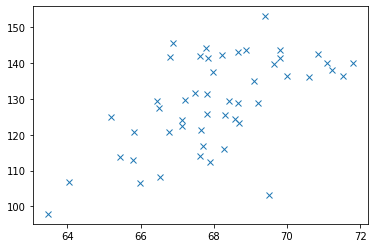

In [40]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.array(_weightRdd), np.array(_heightRdd),'x')
plt.show()

#### boxplot, violinplot

하나의 컬럼만 선택해서 그래프를 그려보자.
* boxplot의 가운데 박스 IQR (Interquartile Range)은 4분위 값의 2, 3번째와 50% 값, 즉 25%~75%의 구간을 의미한다.
그리고 위 아래 가로선은 IQR 값의 1.5배되는 구역을 나타낸다. 값의 분포와 outlier를 확인하기 편리하다.
* violin plot 역시 boxplot과 유사한 기능이지만, 밀도를 보여주고 있다.

In [47]:
tDf = tDf.withColumnRenamed('_c2', 'height')

height = tDf.select("height").toPandas()

In [48]:
height.describe()

,height
count,50.000000
mean,128.842000
std,12.888889
min,97.900000
25%,120.870000
50%,129.500000
75%,140.075000
max,153.030000


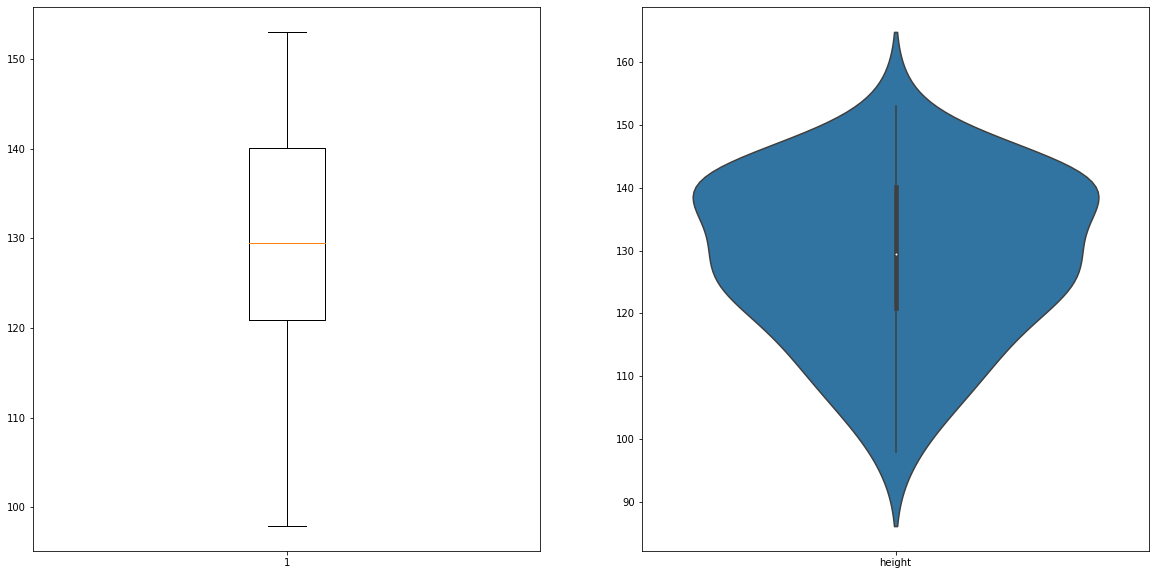

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)  # subplot location
ax1 = plt.boxplot(height)

ax2 = fig.add_subplot(1, 2, 2)
ax2 = sns.violinplot(data=height)

### aggregate functions

avg, collect_list, countDistinct, count, kurtosis, max, min, mean, skewness, stddev, sum, variance 등의 함수가 지원된다.

#### dictionary 형식

agg() 함수에 dictionary 형식으로 ```컬렴명: aggregate functions```으로 적어준다.

In [50]:
tDf.agg({"height":"count"}).show()

+-------------+
|count(height)|
+-------------+
|           50|
+-------------+



In [51]:
tDf.agg({"height":"kurtosis"}).show()

+-------------------+
|   kurtosis(height)|
+-------------------+
|-0.6127861004407515|
+-------------------+



In [52]:
tDf.agg({"height":"avg"}).show()

+-----------+
|avg(height)|
+-----------+
|    128.842|
+-----------+



#### F 함수

In [53]:
from pyspark.sql import functions as F
tDf.agg(F.min("height")).show()

+-----------+
|min(height)|
+-----------+
|       97.9|
+-----------+



### 컬럼 조회 select

컬럼은 아래와 같이 ```select()```로 선택할 수 있다.
컬럼은 그 명칭을 사용하거나 ```myDf.name```, 인덱스 ```myDf['name']```로 선택할 수 있다.

컬럼 선택 | 예제 | 권고
-----|-----|-----
점 연산자로 컬럼을 선택 | myDf.name | N
인덱스로 컬럼을 선택 | myDf['name'] | Y

#### 컬럼명으로 직접 조회 못해

컬럼명만 아래와 같이 적어주어도 조회할 수 없다.

In [54]:
myDf['name']

Column<'name'>

또는 컬럼 데이터를 조회하기 위해 컬럼에 show(), collect() 함수를 사용해서는 안된다. ```select()```를 사용해서 컬럼을 읽을 수 있다.

In [55]:
myDf['name'].show()

TypeError: 'Column' object is not callable

#### 컬럼 조회

In [56]:
_name=myDf.select('name')
_name.show()

+-------+
|   name|
+-------+
|kim, js|
|lee, sm|
|lim, yg|
|    lee|
+-------+



여러 컬럼을 조회하기 위해서는 해당 컬럼을 넣어주면 된다.

In [57]:
_name=myDf.select('name', 'height').show()

+-------+------+
|   name|height|
+-------+------+
|kim, js|   170|
|lee, sm|   175|
|lim, yg|   180|
|    lee|   170|
+-------+------+



또는 리스트를 넣어주어 여러 컬럼을 선택할 수도 있다.
**리스트를 풀어야 하므로, 앞서 배웠던 ```*``` 연산자**를 사용한다.

In [58]:
cols = ['name', 'height']
myDf.select(*cols).show()

+-------+------+
|   name|height|
+-------+------+
|kim, js|   170|
|lee, sm|   175|
|lim, yg|   180|
|    lee|   170|
+-------+------+



#### 컬럼을 List로 변환

select() 함수는 Row()로 구성된 컬럼을 선택하게 된다.

In [35]:
myDf.select('name').collect()

NameError: name 'myDf' is not defined

List로 변환하려면, map() 함수로는 가능하지 않다.

In [36]:
myDf.select('name').rdd.map(lambda x: x).collect()

NameError: name 'myDf' is not defined

2차원 Row List를 제거하기 위해서 인덱스를 사용하면 된다.

In [59]:
myDf.select('name').rdd.map(lambda x: x[0]).collect()

['kim, js', 'lee, sm', 'lim, yg', 'lee']

또는  flatMap()으로 2차원 구조 Row List를 1차원 List로 변환한다.

In [60]:
myDf.select('name').rdd.flatMap(lambda x: x).collect()

['kim, js', 'lee, sm', 'lim, yg', 'lee']

#### select like

```%``` 연산자는 0 또는 그 이상의 문자를 의미한다.

In [61]:
myDf.select("name", "height", myDf.name.like("%lee%")).show()

+-------+------+---------------+
|   name|height|name LIKE %lee%|
+-------+------+---------------+
|kim, js|   170|          false|
|lee, sm|   175|           true|
|lim, yg|   180|          false|
|    lee|   170|           true|
+-------+------+---------------+



#### select startswith

In [62]:
myDf.select("name", "height", myDf.name.startswith("kim")).show()

+-------+------+---------------------+
|   name|height|startswith(name, kim)|
+-------+------+---------------------+
|kim, js|   170|                 true|
|lee, sm|   175|                false|
|lim, yg|   180|                false|
|    lee|   170|                false|
+-------+------+---------------------+



#### select endswith

In [41]:
myDf.select("name", "height", myDf.name.endswith("lee")).show()

NameError: name 'myDf' is not defined

### alias

이름을 변경할 경우 alias() 함수를 사용할 수 있다.

DataFrame의 명칭을 변경해보자.

In [65]:
myDf1 = myDf.alias("myDf1")
myDf1.show()

+---+----+-------+------+---------+-------+-----+
|_c0|year|   name|height|nameUpper|heightD|yearI|
+---+----+-------+------+---------+-------+-----+
|  0|   1|kim, js|   170|  KIM, JS|  170.0|    1|
|  1|   1|lee, sm|   175|  LEE, SM|  175.0|    1|
|  2|   2|lim, yg|   180|  LIM, YG|  180.0|    2|
|  3|   2|    lee|   170|      LEE|  170.0|    2|
+---+----+-------+------+---------+-------+-----+



컬럼의 명칭을 변경해보자.
그러기 위해서는 우선 컬럼을 **```select()```** 함수로 골라낸 후, **```alias```**로 **컬럼명**을 정할 수 있다.
name 컬럼을 **```substr```**으로 1,3문자를 선택한다.

In [66]:
myDf1.select(myDf1.name.substr(1,3).alias("short name")).show(3)

+----------+
|short name|
+----------+
|       kim|
|       lee|
|       lim|
+----------+
only showing top 3 rows



#### 행과 열을 선택 select, when, otherwise

In [67]:
from pyspark.sql.functions import when
myDf.select("height", when(myDf.height < 175, 1).otherwise(0)).show()

+------+------------------------------------------+
|height|CASE WHEN (height < 175) THEN 1 ELSE 0 END|
+------+------------------------------------------+
|   170|                                         1|
|   175|                                         0|
|   180|                                         0|
|   170|                                         1|
+------+------------------------------------------+



alias 명령어로 컬럼을 변경해 줄 수 있다.

In [70]:
from pyspark.sql.functions import when
myDf.select("height", (when(myDf.height < 175, 1).otherwise(0)).alias('<175')).show()

+------+----+
|height|<175|
+------+----+
|   170|   1|
|   175|   0|
|   180|   0|
|   170|   1|
+------+----+



또는 0, 1이 아닌 문자열로 생성할 수 있다.

In [71]:
from pyspark.sql.functions import when
_myDf=myDf.select(when(myDf['heightD'] >175.0, ">175").otherwise("<175").alias("how tall"))

In [72]:
_myDf.show()

+--------+
|how tall|
+--------+
|    <175|
|    <175|
|    >175|
|    <175|
+--------+



withColumn() 함수를 사용하면, DataFrame에 컬럼을 추가하게 된다.

In [93]:
_myDf = myDf.withColumn('how tall', when(myDf['heightD'] >175.0, ">175").otherwise("<175"))
_myDf.show()

+---+----+-------+------+---------+-------+-----+--------+
|_c0|year|   name|height|nameUpper|heightD|yearI|how tall|
+---+----+-------+------+---------+-------+-----+--------+
|  0|   1|kim, js|   170|  KIM, JS|  170.0|    1|    <175|
|  1|   1|lee, sm|   175|  LEE, SM|  175.0|    1|    <175|
|  2|   2|lim, yg|   180|  LIM, YG|  180.0|    2|    >175|
|  3|   2|    lee|   170|      LEE|  170.0|    2|    <175|
+---+----+-------+------+---------+-------+-----+--------+



#### 행과 열을 선택  where, select


DataFrame은 관계형데이터베이스의 테이블과 매우 유사하다. **SQL 명령**을 사용하듯이 ```where()```, ```select()```, ```groupby()``` 함수를 사용할 수 있다.

* 행: ```where()```에 따라 컬럼의 **조건에 맞는 행을 선택**하고 (filter),
* 열: 앞서 배운 ```select()```로 열을 선택

In [75]:
myDf.where(myDf['height'] < 175).show()

+---+----+-------+------+---------+-------+-----+
|_c0|year|   name|height|nameUpper|heightD|yearI|
+---+----+-------+------+---------+-------+-----+
|  0|   1|kim, js|   170|  KIM, JS|  170.0|    1|
|  3|   2|    lee|   170|      LEE|  170.0|    2|
+---+----+-------+------+---------+-------+-----+



In [76]:
myDf.where(myDf['height'] < 175)\
    .select(myDf['name'], myDf['height']).show()

+-------+------+
|   name|height|
+-------+------+
|kim, js|   170|
|    lee|   170|
+-------+------+



### filter

```filter()```는 조건에 따라 데이터를 걸러낸다.
앞서 배웠던 ```where()```와 유사한 기능을 수행한다.

In [77]:
myDf.filter(myDf['height'] > 175).show()

+---+----+-------+------+---------+-------+-----+
|_c0|year|   name|height|nameUpper|heightD|yearI|
+---+----+-------+------+---------+-------+-----+
|  2|   2|lim, yg|   180|  LIM, YG|  180.0|    2|
+---+----+-------+------+---------+-------+-----+



### regexp_replace 컬럼의 내용 변경

In [79]:
from pyspark.sql.functions import *

_heightDf = myDf.withColumn('nameNew', regexp_replace('name', 'lee', 'lim'))
_heightDf.show()

+---+----+-------+------+---------+-------+-----+-------+
|_c0|year|   name|height|nameUpper|heightD|yearI|nameNew|
+---+----+-------+------+---------+-------+-----+-------+
|  0|   1|kim, js|   170|  KIM, JS|  170.0|    1|kim, js|
|  1|   1|lee, sm|   175|  LEE, SM|  175.0|    1|lim, sm|
|  2|   2|lim, yg|   180|  LIM, YG|  180.0|    2|lim, yg|
|  3|   2|    lee|   170|      LEE|  170.0|    2|    lim|
+---+----+-------+------+---------+-------+-----+-------+



### groupBy

컬럼을 학년에 따라,
```groupBy()```하면 아래와 같이 데이터만 집단화하게 된다.
집단화하면 개수를 세거나, 합계를 내거나 어떤 통계량을 계산이 필요하다.

In [80]:
myDf.groupby(myDf['year'])

#### groupBy하고 max

컬럼을 기준으로 구분지어서 평균, 합계, 갯수, 최대, 최소 등을 구할 수 있다.
첫 컬럼 학년을 ```groupby()```해서 최대값 ```max()```를 구해보자.

In [81]:
myDf.groupby(myDf['year']).max().show()

+----+--------+---------+-----------+------------+----------+
|year|max(_c0)|max(year)|max(height)|max(heightD)|max(yearI)|
+----+--------+---------+-----------+------------+----------+
|   1|       1|        1|        175|       175.0|         1|
|   2|       3|        2|        180|       180.0|         2|
+----+--------+---------+-----------+------------+----------+



#### groupBy, agg

```agg()```는 합계 함수를 계산할 수 있으며, 지원하는 함수는 ```avg, max, min, sum, count```이다.

```year``` 컬럼에 대해 ```agg()``` 함수로 계산할 수 있다.

dictionary 형식으로 key는 컬럼명, value는 합계 함수를 적어준다.
예를 들어 {"heightD":"avg"}에서 "heightD"는 컬럼명, "avg"는 합계함수이다.

In [82]:
myDf.groupBy('year').agg({"heightD":"avg"}).show()

+----+------------+
|year|avg(heightD)|
+----+------------+
|   1|       172.5|
|   2|       175.0|
+----+------------+



#### groupBy 국가별 인원수

월드컵 데이터를 groupBy 해보자.

In [87]:
import requests
from pyspark.sql import Row 
from pyspark.sql.types import DateType

# read url json
r=requests.get("https://raw.githubusercontent.com/jokecamp/FootballData/master/World%20Cups/all-world-cup-players.json")
wc=r.json()

# read dictionary into Row
wcDf = spark.createDataFrame(Row(**x) for x in wc)

# cast DoB string into date, Number string into integer
wcDfCasted = wcDf.withColumn('date3', wcDf['DateOfBirth'].cast(DateType()))
wcDfCasted = wcDfCasted.withColumn('NumberInt', wcDfCasted['Number'].cast("integer"))

wcDfCasted.take(1)

[Row(Competition='World Cup', Year=1930, Team='Argentina', Number='', Position='GK', FullName='Ãngel Bossio', Club='Club AtlÃ©tico Talleres de Remedios de Escalada', ClubCountry='Argentina', DateOfBirth='1905-5-5', IsCaptain=False, date3=datetime.date(1905, 5, 5), NumberInt=None)]

In [88]:
wcDf.groupBy(wcDf.ClubCountry).count().show()

+-----------+-----+
|ClubCountry|count|
+-----------+-----+
|   England |    4|
|   Paraguay|   93|
|     Russia|   51|
|        POL|   11|
|        BRA|   27|
|    Senegal|    1|
|     Sweden|  154|
|   Colombia|    1|
|        FRA|  155|
|        ALG|    8|
|   England |    1|
|       RUS |    1|
|     Turkey|   65|
|      Zaire|   22|
|       Iraq|   22|
|    Germany|  206|
|        RSA|   16|
|        ITA|  224|
|        UKR|   38|
|        GHA|    8|
+-----------+-----+
only showing top 20 rows



#### groupBy 국가별 포지션별 인원수

In [89]:
wcDf.groupBy('ClubCountry').pivot('Position').count().show()

+-----------+----+----+----+----+----+
|ClubCountry|    |  DF|  FW|  GK|  MF|
+-----------+----+----+----+----+----+
|   England |null|null|   2|null|   2|
|   Paraguay|null|  26|  37|  10|  20|
|     Russia|null|  20|  11|   4|  16|
|        POL|null|   2|   2|   3|   4|
|        BRA|null|   7|   5|   4|  11|
|    Senegal|null|null|null|   1|null|
|     Sweden|null|  40|  47|  25|  42|
|   Colombia|null|null|   1|null|null|
|        ALG|null|   2|null|   6|null|
|        FRA|null|  46|  41|  18|  50|
|   England |null|null|null|null|   1|
|       RUS |null|null|null|   1|null|
|     Turkey|null|  20|  13|  12|  20|
|      Zaire|null|   6|   5|   3|   8|
|       Iraq|null|   6|   4|   3|   9|
|    Germany|null|  64|  51|  16|  75|
|        RSA|null|   5|   2|   3|   6|
|        UKR|null|  13|   7|   4|  14|
|        ITA|null|  74|  42|  19|  89|
|        CMR|null|   1|   1|   1|null|
+-----------+----+----+----+----+----+
only showing top 20 rows



### F 함수

또는 아래와 같이 별도 ```pyspark.sql.functions```을 사용할 수 있다.
앞서 pyspark.sql.functions은 함수이므로, ```from pyspark.sql.functions import split``` 이렇게 한다.
또는 ```from pyspark.sql import functions as F```라고 한다.

In [90]:
from pyspark.sql import functions as F

myDf.agg(F.min(myDf.heightD),F.max(myDf.heightD),F.avg(myDf.heightD),F.sum(myDf.heightD)).show()

+------------+------------+------------+------------+
|min(heightD)|max(heightD)|avg(heightD)|sum(heightD)|
+------------+------------+------------+------------+
|       170.0|       180.0|      173.75|       695.0|
+------------+------------+------------+------------+



### 행 추가

행을 추가하려면, DataFrame을 서로 합치는 방법으로 가능하다.
추가할 행으로 DataFrame을 만들고, union() 함수로 합쳐야 한다.

createFrame() 함수에는 리스트를 넣어주어야 한다.

In [91]:
toAppendDf = spark.createDataFrame([Row(4, 1, "choi, js", 177)])

In [96]:
_myDf = myDf
_myDf.show()

+---+----+-------+------+---------+-------+-----+
|_c0|year|   name|height|nameUpper|heightD|yearI|
+---+----+-------+------+---------+-------+-----+
|  0|   1|kim, js|   170|  KIM, JS|  170.0|    1|
|  1|   1|lee, sm|   175|  LEE, SM|  175.0|    1|
|  2|   2|lim, yg|   180|  LIM, YG|  180.0|    2|
|  3|   2|    lee|   170|      LEE|  170.0|    2|
+---+----+-------+------+---------+-------+-----+



In [97]:
_myDf = myDf.union(toAppendDf)

AnalysisException: Union can only be performed on tables with the same number of columns, but the first table has 7 columns and the second table has 4 columns;
'Union false, false
:- Project [_c0#16, year#17, name#18, height#19, nameUpper#79, heightD#128, <lambda>(year#17) AS yearI#136]
:  +- Project [_c0#16, year#17, name#18, height#19, nameUpper#79, <lambda>(height#19) AS heightD#128]
:     +- Project [_c0#16, year#17, name#18, height#19, nameUpper#79, <lambda>(height#19) AS heightD#120]
:        +- Project [_c0#16, year#17, name#18, height#19, nameUpper#79, <lambda>(height#19) AS heightD#112]
:           +- Project [_c0#16, year#17, name#18, height#19, uppercase(name#18) AS nameUpper#79]
:              +- Project [_c0#16, year#17, name#18, height#19, uppercase(name#18) AS nameUpper#46]
:                 +- Relation[_c0#16,year#17,name#18,height#19] csv
+- LogicalRDD [_1#5283L, _2#5284L, _3#5285, _4#5286L], false


In [ ]:
_myDf.show()

### partition

#### partition 개수

In [60]:
myDf.rdd.getNumPartitions()

NameError: name 'myDf' is not defined

#### repartition

repartition()은 partition의 개수를 늘리거나 줄이거나 재설정한다.

In [61]:
_myDf = myDf.repartition(4)
print(_myDf.rdd.getNumPartitions())

NameError: name 'myDf' is not defined

#### coalesce

coalesce()는 partition을 **줄일 때** 사용한다.
앞서 4개의 partition을 가진 ```_myDf```를 2로 줄여보자.

In [62]:
_myDf2 = _myDf.coalesce(2)
print(_myDf2.rdd.getNumPartitions())

NameError: name '_myDf' is not defined

### 통계 요약 describe

column이 연산가능한 데이터타잎인 경우, 요약 값을 볼 수 있다.

In [98]:
myDf.describe().show()

+-------+------------------+------------------+-------+------------------+---------+------------------+------------------+
|summary|               _c0|              year|   name|            height|nameUpper|           heightD|             yearI|
+-------+------------------+------------------+-------+------------------+---------+------------------+------------------+
|  count|                 4|                 4|      4|                 4|        4|                 4|                 4|
|   mean|               1.5|               1.5|   null|            173.75|     null|            173.75|               1.5|
| stddev|1.2909944487358056|0.5773502691896257|   null|4.7871355387816905|     null|4.7871355387816905|0.5773502691896257|
|    min|                 0|                 1|kim, js|               170|  KIM, JS|             170.0|                 1|
|    max|                 3|                 2|lim, yg|               180|  LIM, YG|             180.0|                 2|
+-------+-------

### 결측값

결측값을 채우는 함수이다.
* df.na.fill(0) 모든 컬럼의 na를 0으로 교체
* df.fillna( { 'c0':0, 'c1':0 } ) 컬럼 c0, c1의 na를 0으로 교체

결측값을 삭제할 수도 있다.
* df.na.drop(subset=["c0"])

In [101]:
from pyspark.sql import functions as F
myDf.where(F.col("height").isNull())

DataFrame[_c0: int, year: int, name: string, height: int, nameUpper: string, heightD: double, yearI: int]

In [65]:
from pyspark.sql.functions import isnan, when, count, col
myDf.select([count(when(isnan(c), c)).alias(c) for c in myDf.columns]).show()

NameError: name 'myDf' is not defined

In [100]:
from pyspark.sql.functions import isnan, when, count, col
myDf.select([count(when(col(c).isNull(), c)).alias(c) for c in myDf.columns]).show()

+---+----+----+------+---------+-------+-----+
|_c0|year|name|height|nameUpper|heightD|yearI|
+---+----+----+------+---------+-------+-----+
|  0|   0|   0|     0|        0|      0|    0|
+---+----+----+------+---------+-------+-----+



## 문제: 년별 분기별 대여건수

서울시 열린데이터 https://data.seoul.go.kr/ 에서 제공하는 ```서울특별시_공공자전거 일별 대여건수_(2018~2019.03).csv```를 분석해보자.
파일은 웹 검색을 해서 다운로드해서 사용하면 된다.
데이터는 일자별로, 대여건수이이고, 몇 줄만 출력해보면 다음과 같다.

|      date| count|
|----------|------|
|2018-01-01|  4950|
|2018-01-02|  7136|
|2018-01-03|  7156|
|2018-01-04|  7102|
|2018-01-05|  7705|

### 문제 1-1: 년도별 대여건수 합계
데이터는 2018, 2019년 15개월 간의 대여건수이다. 년도별로 대여건수의 합계를 계산해서 출력하자.

|year|sum(count)|
|----|----------|
|2018|  10124874|
|2019|   1871935|


### 문제 1-2: 년도별, 월별 대여건수 합계
년별, 월별로 대여건수를 계산하여 합계를 계산하여 출력한다.

### 문제 1-3: 년도별, 월별 대여건수 그래프
문제 1-2의 출력을 선 그래프로 그려보자.

### 데이터 읽기

서울시 열린데이터에서 데이터 ```서울특별시_공공자전거 일별 대여건수_(2018~2019.03).csv``` 를 다운로드 받아서 저장한다.
csv 형식으로 schema는 자동 인식하도록 읽는다.
일자는 ```timestamp```로 건수는 ```integer```로 인식되었다.

In [66]:
_bicycle = spark.read.format('com.databricks.spark.csv')\
    .options(header='true', inferschema='true').load('data/seoulBicycleDailyCount_2018_201903.csv')

NameError: name 'spark' is not defined

In [67]:
_bicycle.printSchema()

NameError: name '_bicycle' is not defined

전체 건수는 455건, 5건의 데이터만 읽어보자.

In [68]:
_bicycle.count()

NameError: name '_bicycle' is not defined

In [69]:
_bicycle.show(5)

NameError: name '_bicycle' is not defined

### 컬럼명 변경

앞서 보듯이 파일을 읽으면서 컬럼명이 인식되었는데 " count"가 맨 앞에 공백이 하나 있게 되어 변경해보자.
일단 붙여진 컬럼의 명칭을 변경하려면 ```withColumnRenamed()```를 연결하여 사용한다.

In [70]:
bicycle=_bicycle\
    .withColumnRenamed("date", "Date")\
    .withColumnRenamed(" count", "Count")

NameError: name '_bicycle' is not defined

### 컬럼 만들기: substr

```substr()``` 함수는 인자가 2개로서, 앞글자 '1'은 시작 '4'는 4글자를 의미한다.

In [71]:
bicycle=bicycle.withColumn("year",bicycle.Date.substr(1, 4))

NameError: name 'bicycle' is not defined

In [ ]:
bicycle.printSchema()

In [72]:
bicycle=bicycle.withColumn("month",bicycle.Date.substr(6, 2))

NameError: name 'bicycle' is not defined

In [ ]:
bicycle.show(5)

### 컬럼 만들기: F 함수

함수를 이용해 년, 월, 일 등을 추출할 수 있다.
먼저 앞서 생성된 column을 삭제하고 나서 해보자.
여러 컬럼을 삭제하기 위해서는 ```*```를 앞에 붙여 준다.
물론 하나씩 삭제할 수도 있고, 그러면 별표는 불필요하다.

In [73]:
columns_to_drop = ['year','month']
df = bicycle.drop(*columns_to_drop)

NameError: name 'bicycle' is not defined

year, month 컬럼이 삭제되고 Date, Count 컬럼만 남겨졌다.

In [74]:
df.printSchema()

NameError: name 'df' is not defined

pyspark.sql.functions의 year(), month() 함수를 사용하여 년, 월을 추출하자.

In [75]:
import pyspark.sql.functions as F
bicycle = bicycle\
    .withColumn('year', F.year('date'))\
    .withColumn('month', F.month('date'))

NameError: name 'bicycle' is not defined

In [ ]:
bicycle.printSchema()

앞서 substr() 결과와 비교해보자. year, month가 올바르게 추출되었다.

In [76]:
bicycle.show(5)

NameError: name 'bicycle' is not defined

show()는 앞 부분 보여주고 있다. 월이 1만 보여서, 다른 월의 결과를 보고 싶다면 filter()해주면 된다.

In [77]:
bicycle.filter(bicycle.month == 2).show(3)

NameError: name 'bicycle' is not defined

### 분기

1월 2월 3월은 1분기, 4~6은 2분기, 7~9는 3분기, 10~12는 4분기로 구분한다.

In [78]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
def classifyQuarter(s):
    q=""
    if 1<=s and s< 4:
        q="Q1"
    elif 4<=s and s<7:
        q="Q2"
    elif 7<=s and s<10:
        q="Q3"
    elif 10<=s and s<=12:
        q="Q4"
    else:
        q="no"
    return q

In [79]:
quarter_udf = udf(classifyQuarter, StringType())

In [80]:
bicycle=bicycle.withColumn("quarter", quarter_udf(bicycle.month))

NameError: name 'bicycle' is not defined

잘 분류되었는지 건수를 확인해보자.

In [81]:
bicycle.groupBy('quarter').count().show()

NameError: name 'bicycle' is not defined

In [ ]:
bicycle.show(5)

### 년도별 대여건수 합계

In [82]:
bicycle.groupBy('year').agg({"count":"sum"}).show()

NameError: name 'bicycle' is not defined

### 분기별 대여건수 합계

In [83]:
bicycle.groupBy('quarter').agg({"count":"sum"}).show()

NameError: name 'bicycle' is not defined

In [84]:
bicycle.groupBy('quarter').agg({"count":"avg"}).show()

NameError: name 'bicycle' is not defined

### 년도별, 월별 (분기별) 대여건수 합계

In [85]:
bicycle.groupBy('year').pivot('month').agg({"count":"sum"}).show()

NameError: name 'bicycle' is not defined

In [ ]:
bicycle.groupBy('year').pivot('quarter').agg({"count":"sum"}).show()

### Pandas pivot

In [86]:
import pandas as pd
import numpy as np
bicycleP = bicycle.toPandas()

NameError: name 'bicycle' is not defined

Pandas의 info() 함수는 DataFrame의 컬럼, 데이터타입 dtypes를 출력한다.

In [87]:
bicycleP.info()

NameError: name 'bicycleP' is not defined

* 년도별 대여건수 합계

In [88]:
#bicycleP.groupby('year').aggregate({'Count':np.sum})
bicycleP.groupby('year').aggregate({'Count':'sum'})

NameError: name 'bicycleP' is not defined

* 년도별, 월별 대여건수 합계

index는 행, columns는 열 데이터를 정의한다.

In [89]:
pd.pivot_table(bicycleP, values = 'Count', index = ['year'], columns = ['month'], aggfunc= 'sum')

NameError: name 'bicycleP' is not defined

2018년만 선택해서 년도별 x 분기별 대여건수를 출력해보자.

In [90]:
bicycleP2018=bicycleP[bicycleP['year']==2018]

NameError: name 'bicycleP' is not defined

In [ ]:
bicycleP2018byQ = pd.pivot_table(bicycleP2018, values = 'Count', index = ['year'], columns = ['quarter'], aggfunc= 'sum')

In [91]:
bicycleP2018byQ.iloc[:,0:4]

NameError: name 'bicycleP2018byQ' is not defined

### 년별 월별 대여건수 그래프

앞장 RDD에서 만들어진 단어빈도는 리스트에 저장되었다. 따라서 리스트에서 데이터를 추출하여 그래프를 그렸다.
groupBy에서 생성된 월별 대여건수는 pandas로 변환하여 그려보자.

#### 년별 월별 대여건수 생성

In [92]:
sumMonthly=bicycle.groupBy('year').pivot('month').agg({"count":"sum"})

NameError: name 'bicycle' is not defined

In [93]:
pdf=sumMonthly.toPandas()

NameError: name 'sumMonthly' is not defined

In [94]:
pdf.head()

NameError: name 'pdf' is not defined

#### 

위 데이터에서 'year' 컬럼이 없어야 그래프를 그릴 수 있다.
* drop() 명령어에 삭제할 컬럼명 'year'와 1을 적어준다.
0은 행 (index), 1은 컬럼을 삭제한다는 의미이다.
* transpose() 함수를 통해 열로 변환하여 (행 데이터는 plot을 할 수 없다), 그래프를 그린다.

In [95]:
my=pdf.drop('year', 1).transpose()

NameError: name 'pdf' is not defined

위 pdf를 변환한 my를 출력하면, 명령어가 적용되어 year 컬럼이 삭제되고, transpose되어 있다.

In [96]:
my

NameError: name 'my' is not defined

```plot()``` 함수는 컬럼을 적지 않으면 모든 컬럼에 대해서 plot한다.

In [97]:
my.columns=[2018, 2019]

NameError: name 'my' is not defined

In [ ]:
my.plot(kind='line')

## S.6 Spark SQL

관계형 데이터베이스 RDB에서 사용하는 Sql을 사용하여 DataFrame으로부터 데이터를 조회할 수 있다. DataFrame과 달리, RDD는 비구조적인 경우에 사용하므로 테이블로 변환한 후 Sql을 사용하게 된다.

* Spark SQL 구성

구분 | 설명
-----|-----
Language API | Python, Java, Scala, Hive QL API를 제공
Schema RDD | RDD에 Schema를 적용해 임시 테이블로 변환한다.<br>createOrReplaceTempView<br>createGlobalTempView
Data Sources | 다양한 형식 지원 - HDFS, Cassandra, HBase, RDB

앞서 만들어 놓은 World Cup 데이터를 사용한다.

In [98]:
wcDf.printSchema()

NameError: name 'wcDf' is not defined

이제 임시 테이블 ```wc```를 만들고, Sql문으로 데이터를 조회해보자.

In [99]:
wcDf.createOrReplaceTempView("wc")
spark.sql("select Club,Team,Year from wc").show(1)

NameError: name 'wcDf' is not defined

In [100]:
wcPlayers=spark.sql("select FullName,Club,Team,Year from wc")
wcPlayers.show(1)

NameError: name 'spark' is not defined

In [101]:
spark.catalog.listTables()

NameError: name 'spark' is not defined

```wcPlayers```를 RDD로 변환해서 이름만 출력해 보자.

In [102]:
namesRdd=wcPlayers.rdd.map(lambda x: "Full name: "+x[0])
for e in namesRdd.take(5):
    print (e)

NameError: name 'wcPlayers' is not defined

#### sql.functions and join

리스트에 포함되어 있는 과일에 고유번호를 할당해 보자.

In [103]:
bucketDf=spark.createDataFrame([[1,["orange", "apple", "pineapple"]],
                                [2,["watermelon","apple","bananas"]]],
                               ["bucketId","items"])

NameError: name 'spark' is not defined

```truncate```는 행의 값을 잘라내지 않고 출력한다.
```show(bucketDf.count(), truncate=False)```는 모든 행을 완전하게 출력한다.

In [ ]:
bucketDf.show(bucketDf.count(), truncate=False)

* explode

컬럼에 List 또는 배열이 포함된 경우 ```explode()``` 함수는 이를 flat해서 새로운 컬럼을 생성하게 된다.


In [104]:
from pyspark.sql.functions import explode
bDf=bucketDf.select(bucketDf.bucketId, explode(bucketDf.items).alias('item'))

NameError: name 'bucketDf' is not defined

In [ ]:
bDf.show()

또 다른 DataFrame을 생성해보자. 나중에 앞의 DataFrame과 join하게 된다.

In [105]:
fDf=spark.createDataFrame([["orange", "F1"],
                            ["", "F2"],
                            ["pineapple","F3"],
                            ["watermelon","F4"],
                            ["bananas","F5"]],
                            ["item","itemId"])

NameError: name 'spark' is not defined

In [ ]:
fDf.show()

* join

join은 ```inner, cross, outer, full, full_outer, left, left_outer, right, right_outer, left_semi, left_anti``` 여러 종류가 있다. ```inner```기준으로 item이 일치하지 않는 것은 제외하게 된다.

In [106]:
joinDf=fDf.join(bDf, fDf.item==bDf.item, "inner")

NameError: name 'fDf' is not defined

In [107]:
joinDf.select(fDf.itemId,fDf.item,bDf.bucketId).show()

NameError: name 'joinDf' is not defined

## 문제 S-1: 네트워크에 불법적으로 침입하는 사용자의 분석

### 문제

네트워크에 불법적으로 침입하는 시도는 허용되어서는 안된다.
1998년 MIT Lincoln Labs에서 DARPA Intrusion Detection Evaluation Program을 연구하였다.
이 데이터의 일부가 1999년 KDD로 만들어져 배포되고 있다.
https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

### 해결

마지막 행에 attack의 유형이 구분되어 있다. 네트워크 침입 유형의 특징을 분석해 보자.
탐지예방 모델을 구축할 수 있다.


KDD데이터는 41 항목으로 구성되어 있다.

```python
연결(초) | duration: continuous.
프로토콜 (tcp,udp,etc) | protocol_type: symbolic.
서비스 (http,telnet, etc) | service: symbolic.
flag: symbolic.
src_bytes: continuous.
dst_bytes: continuous.
land: symbolic.
wrong_fragment: continuous.
urgent: continuous.
hot: continuous.
num_failed_logins: continuous.
logged_in: symbolic.
num_compromised: continuous.
root_shell: continuous.
su_attempted: continuous.
num_root: continuous.
num_file_creations: continuous.
num_shells: continuous.
num_access_files: continuous.
num_outbound_cmds: continuous.
is_host_login: symbolic.
is_guest_login: symbolic.
count: continuous.
srv_count: continuous.
serror_rate: continuous.
srv_serror_rate: continuous.
rerror_rate: continuous.
srv_rerror_rate: continuous.
same_srv_rate: continuous.
diff_srv_rate: continuous.
srv_diff_host_rate: continuous.
dst_host_count: continuous.
dst_host_srv_count: continuous.
dst_host_same_srv_rate: continuous.
dst_host_diff_srv_rate: continuous|.
dst_host_same_src_port_rate: continuous.
dst_host_srv_diff_host_rate: continuous.
dst_host_serror_rate: continuous.
dst_host_srv_serror_rate: continuous.
dst_host_rerror_rate: continuous.
dst_host_srv_rerror_rate: continuous.
```

### 파일 내려받기

KDD 파일은 **gz** 압축되어 있다. 파일 확장자 'gz'은 'gzip'이라는 압축 도구에서 생성된 파일이다. 지금은 WinZip에서 읽을 수 있다.

In [108]:
import os
_url = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz'
_fname = os.path.join(os.getcwd(),'data','kddcup.data_10_percent.gz')

파일이 로컬 디렉토리 ```data```에 존재하면, 즉 이미 내려받았으므로 또 내려받지 않는다. 그렇지 않을 경우에만 ```urlretrieve()``` 함수로 내려받는다. 오류가 발생하면, (1) 파일이 없거나, (2) 파일을 모두 내려 받지 않았거나, (3) 파일이 깨져있을 수 있다. 내려받은 디렉토리로 가서 그 파일이 존재하는지, winzip같은 유틸리티로 해당 gz을 풀어보고 확인하든지, 적당한 에디터로 해당 파일에 내용이 있는지 확인해야 한다.

In [109]:
from urllib.request import urlretrieve

if(not os.path.exists(_fname)):
    print ("{} data does not exist! retrieving..".format(_fname))
    _f=urlretrieve(_url,_fname)

### RDD 생성

**RDD**는 gz와 같은 **압축파일에서 데이터를 읽어서** 생성할 수 있다.

반면, DataFrame은 구조schema를 정의해야 하기 때문에 쉽지 않다. 여기서는 **오류**가 발생한다.
따라서 RDD를 생성하고 난 후, 그로부터 DataFrame을 생성하고, Sql을 사용한다.

```textFile()``` 함수로 RDD를 생성한다. ```count()```는 행의 수를 돌려주는 action 함수이다. action 함수는 바로 실행되므로 시간이 좀 걸린다.

In [110]:
_rdd = spark.sparkContext.textFile(_fname)

NameError: name 'spark' is not defined

In [ ]:
_rdd.count()

In [111]:
_rdd.take(1)

NameError: name '_rdd' is not defined

```map()``` 함수를 사용하여 csv 형식으로 구성된 파일을 컴마(,)로 분리한다.

In [112]:
_allRdd=_rdd.map(lambda x: x.split(','))

NameError: name '_rdd' is not defined

In [ ]:
_allRdd.take(1)

### 정상, 공격 건수

데이터가 ```normal```인 경우와 아닌 경우로 구분하자.
```filter()```는 41번째 행을 조건에 따라 데이터를 구분한다.
```count()``` 함수로 건수를 계산하면 'normal' 97,278, 'attack'은 396,743 건이다.

침입구분 | 건수
-------|-------
normal | 97278
attack | 396743
전체 | 494021

In [113]:
_normalRdd=_allRdd.filter(lambda x: x[41]=="normal.")
_attackRdd=_allRdd.filter(lambda x: x[41]!="normal.")

NameError: name '_allRdd' is not defined

In [114]:
_normalRdd.count()

NameError: name '_normalRdd' is not defined

In [115]:
_attackRdd.count()

NameError: name '_attackRdd' is not defined

### attack별 건수

**attack 종류**는 41번째 열에 구분되어 있다. 총 494,021건을 정상 'noraml'과 나머지는 'attack'으로 구분한다.
'attack'은 크게 4종류로 나눈다. DOS는 서비스 거부, R2L 원격침입, U2R은 루트권한침입, probing은 탐지이다.

attack 4종류 | 설명 | 41번째 열
-----|-----|-----
DOS | denial-of-service, e.g. syn flood | back, land, neptune, pod, smurf, teardrop
R2L | unauthorized access from a remote machine | ftp_write, guess_passwd, imap, multihop, phf, spy, warezclient, warezmaster
U2R | unauthorized access to local superuser (root) privileges | buffer_overflow, loadmodule, perl, rootkit
probing | surveillance and other probing | ipsweep, nmap, portsweep, satan

열41에 대해 건수를 세어보자.
```reduceByKey()```는 인자로 '함수'가 필요. 키별로 '함수를 사용해서' 계산한다.

In [116]:
_41 = _allRdd.map(lambda x: (x[41], 1))
_41.reduceByKey(lambda x,y: x+y).collect()

NameError: name '_allRdd' is not defined

```groupByKey()```는 키별로 group한다. 위 ```reduceByKey()```와 달리 ```mapValues()```를 사용해 값을 별도로 계산한다는 점에 유의하자.

In [117]:
_41 = _allRdd.map(lambda x: (x[41], 1))
def f(x): return len(x)
_41.groupByKey().mapValues(f).collect()

NameError: name '_allRdd' is not defined

### Dataframe 생성

열 0, 1, 2, 3, 4, 5, 41을 선별하여 스키마를 정해서 RDD를 생성한다.

In [118]:
from pyspark.sql import Row

_csv = _rdd.map(lambda l: l.split(","))
_csvRdd = _csv.map(lambda p: 
    Row(
        duration=int(p[0]), 
        protocol=p[1],
        service=p[2],
        flag=p[3],
        src_bytes=int(p[4]),
        dst_bytes=int(p[5]),
        attack=p[41]
    )
)

NameError: name '_rdd' is not defined

RDD를 Dataframe으로 변환한다.


In [119]:
_df=spark.createDataFrame(_csvRdd)


NameError: name 'spark' is not defined

In [120]:
_df.printSchema()
_df.show(5)

NameError: name '_df' is not defined

### attack 분류

네트워크 침입이 'attack' 또는 'normal'에 따라 구분해서 ```attackB``` 컬럼을 생성한다.

In [121]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
attack_udf = udf(lambda x: "normal" if x =="normal." else "attack", StringType())
myDf=_df.withColumn("attackB", attack_udf(_df.attack))

NameError: name '_df' is not defined

In [122]:
myDf.printSchema()

NameError: name 'myDf' is not defined

네트워크 침입 attack을 세분화하여 normal, dos, r2l, u2r, probling으로 **5종류**로 구분한다.
구분 문자열이 **점('.')**으로 끝난다는 점에 주의하다.

attack 4종류 | 설명 | 41번째 열
-----|-----|-----
DOS | denial-of-service, e.g. syn flood | back, land, neptune, pod, smurf, teardrop
R2L | unauthorized access from a remote machine | ftp_write, guess_passwd, imap, multihop, phf, spy, warezclient, warezmaster
U2R | unauthorized access to local superuser (root) privileges | buffer_overflow, loadmodule, perl, rootkit
probing | surveillance and other probing | ipsweep, nmap, portsweep, satan

위 표에 따라 ```udf()``` 함수를 사용해서 if문으로 'noraml' 및 'attack'을 총 5가지 종류로 구분한다.
반환 값은 ```StringType()```이다.

In [123]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
def classify41(s):
    _5=""
    if s=="normal.":
        _5="normal"
    elif s=="back." or s=="land." or s=="neptune." or s=="pod." or s=="smurf." or s=="teardrop.":
        _5="dos"
    elif s=="ftp_write." or s=="guess_passwd." or s=="imap." or s=="multihop." or s=="phf." or\
        s=="spy." or s=="warezclient." or s=="warezmaster.":
        _5="r2l"
    elif s=="buffer_overflow." or s=="loadmodule." or s=="perl." or s=="rootkit.":
        _5="u2r"
    elif s=="ipsweep." or s=="nmap." or s=="portsweep." or s=="satan.":
        _5="probing"
    return _5

attack5_udf = udf(classify41, StringType())

In [124]:
myDf=myDf.withColumn("attack5", attack5_udf(_df.attack))

NameError: name 'myDf' is not defined

In [125]:
myDf.printSchema()

NameError: name 'myDf' is not defined

잘 분류되었는지 일부 데이터를 살펴보자.

In [126]:
myDf.show(5)

NameError: name 'myDf' is not defined

### attack, normal 특징 분석

```attack5``` 별로 건수를 세어보자.

In [127]:
myDf.groupBy('attack5').count().show()

NameError: name 'myDf' is not defined

```attack5``` 별로 공격의 특징을 분석해보자. 어떤 ```protocol```, ```src_bytes```, ```duration```이 어떤지 계산할 수 있다.

In [128]:
myDf.groupBy("protocol").count().show()

NameError: name 'myDf' is not defined

In [129]:
myDf.groupBy('attackB','protocol').count().show()

NameError: name 'myDf' is not defined

In [130]:
myDf.groupBy('attackB').pivot('protocol').count().show()

NameError: name 'myDf' is not defined

In [131]:
myDf.groupBy('attack5').pivot('protocol').avg('src_bytes').show()

NameError: name 'myDf' is not defined

In [132]:
myDf.groupBy('attack5').avg('duration').show()

NameError: name 'myDf' is not defined

In [133]:
from pyspark.sql import functions as F
myDf.groupBy('attackB').pivot('protocol').agg(F.max('dst_bytes')).show()

NameError: name 'myDf' is not defined

좀 더 세밀한 조건으로 ```duration>1000)```, ```dst_bytes==0```인 경우의 건수를 계산할 수 있다.

In [134]:
myDf.select("protocol", "duration", "dst_bytes")\
    .filter(_df.duration>1000)\
    .filter(_df.dst_bytes==0)\
    .groupBy("protocol")\
    .count()\
    .show()

NameError: name 'myDf' is not defined

### SQL

SQL을 사용해보자. 위에 사용했던 ```_df```에서 임시 테이블 ```_tab```을 생성한다.

In [135]:
_df.registerTempTable("_tab")

NameError: name '_df' is not defined

In [136]:
tcp_interactions = spark.sql(
"""
    SELECT duration, dst_bytes FROM _tab
    WHERE protocol = 'tcp' AND duration > 1000 AND dst_bytes = 0
""")

NameError: name 'spark' is not defined

In [137]:
tcp_interactions.show(5)

NameError: name 'tcp_interactions' is not defined

In [138]:
tcp_interactions_out = tcp_interactions.rdd\
    .map(lambda p: "Duration: {}, Dest. bytes: {}".format(p.duration, p.dst_bytes))

NameError: name 'tcp_interactions' is not defined

In [139]:
for i,ti_out in enumerate(tcp_interactions_out.collect()):
    if(i%10==0):
        print ti_out

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(ti_out)? (<ipython-input-139-a9ffbd19a28f>, line 3)

## 문제 S-2: Twitter JSON 데이터 읽기

* [nok] 현재 디렉토리 _tweet.json
    * src/ds_twitter_3.py로 변경 (ds_twitter_3.json으로 저장)



* Twitter JSON을 읽을 경우

구분 | 예
-------|-------
unicode를 사용하면 backslash | "{\"created_at\":\"Sun Nov 13 00:05:19 +0000 2016\"
보통 | {"created_at":"Sun Nov 13 00:05:19 +0000 2016"

* allowBackslashEscapingAnyCharacter

## 문제 S-3: 뉴욕에서 출생한 신생아 분석

### 뉴욕에서 출생한 신생아가 년도별 성별에 차이가 있을까?

뉴욕에서 2007년 출생한 유아의 기록이다.
https://health.data.ny.gov/Health/Baby-Names-Beginning-2007/jxy9-yhdk

Column Name | 설명
-----|-----
Year | Year data was collected.
First Name | 이름
County | Location where the baby’s mother resided as stated on their birth certificate.
Sex | F= Female M= Male
Count | Five (5) or more of the same baby name in a county outside of NYC; Ten (10) or more of the same baby name in a NYC borough.


## 문제 S-4: 우버 택시의 운행기록 분석

* 질문: 2015년 가장 많은 운행을 한 base는?
https://github.com/tmcgrath/spark-with-python-course/blob/master/Spark-SQL-CSV-with-Python.ipynb

* fivethirtyeight
    * git clone https://github.com/fivethirtyeight/uber-tlc-foil-response.git
        daily Uber trip statistics in January and February 2015

dispatching_base_number | date | active_vehicles | trips
----------|----------|----------|----------
B02512 | 1/1/2015 | 190 | 1132
B02765 | 1/1/2015 | 225 | 1765


## 문제 S-5: JDBC를 사용해서 데이터 읽기

* jdbc를 연결하는 방식은 Java와 같이 'driver', 'url'을 설정하면 된다.
* 여기서는 sqlite를 실습한다.

* sqlite와 같이 Spark 패키지가 없는 경우, jar를 다운로드하고
설정파일 conf/spark-defaults.conf에 'spark.driver.extraClassPath'를 추가한다.


## S.7 MongoDB Spark connector

* Spark에서 MongoDB에 저장된 데이터를 읽어 온다.
* 참조: pymongo-spark (Spark와 PyMongo를 사용하는 Python 라이브러리, 설치하려면 pip install pymongo-spark)


### S.7.1 설정

* 참조 https://docs.mongodb.com/spark-connector/
* 설정파일 conf/spark-defaults.conf 수정
    * Spark 버전에 맞는 jar를 선택한다.
    * MongoDB<3.2인 경우, spark.mongodb.input.partitioner가 필요하다.
    * packages 여러 개를 넣을 경우에는 컴마로 분리한다.

```python
$vim conf/spark-defaults.conf 
spark.jars.packages=org.mongodb.spark:mongo-spark-connector_2.10:1.1.0
spark.mongodb.input.partitioner=MongoPaginateBySizePartitioner
```

In [140]:
print spark.conf.get('spark.jars.packages')

SyntaxError: invalid syntax (<ipython-input-140-8d7789a7805a>, line 1)

### S.7.2 uri

* SparkSession에 uri를 설정할 수 있다. 연결에 필요한 ip, database, collection을 정의한다.

```python
spark = pyspark.sql.SparkSession.builder\
    .master("local")\
    .appName("myApp")\
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/myDB.ds_spark_df_mongo") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/myDB.ds_spark_df_mongo") \
    .getOrCreate()
```

* 또는 실행시점에 설정할 수 있다 (아래 참조)


### S.7.3 MongoDB Python API

* format은 "com.mongodb.spark.sql.DefaultSource"로 설정한다.
* 'option'을 사용해서 실행시점에 Database, Colleciton 명을 설정할 수 있다.

구분 | 명령어 예
-----|-----
쓰기 | DataFrame.write.format("com.mongodb.spark.sql.DefaultSource")\<br>.mode("overwrite")\<br>.option("uri","mongodb://127.0.0.1/myDB.ds_spark_ml")\<br>.save()
읽기 | spark.read.format("com.mongodb.spark.sql.DefaultSource")\<br>.option("uri","mongodb://127.0.0.1/ds_twitter.seoul")\<br>.load()


### S.7.4 연습으로 쓰기, 읽기

In [141]:
people = spark.createDataFrame([("kim",10),("lee",20),("choi",30),("park",40)],["name", "age"])

NameError: name 'spark' is not defined

In [142]:
people.write.format("com.mongodb.spark.sql.DefaultSource")\
    .mode("append")\
    .option("uri","mongodb://127.0.0.1/myDB.ds_spark_ml")\
    .save()

NameError: name 'people' is not defined

In [ ]:
df = spark.read.format("com.mongodb.spark.sql.DefaultSource")\
    .option("uri","mongodb://127.0.0.1/myDB.ds_spark_ml")\
    .load()

In [143]:
df.printSchema()

NameError: name 'df' is not defined

In [144]:
df.select('name').show(3)

NameError: name 'df' is not defined

In [145]:
df = spark.read.format("com.mongodb.spark.sql.DefaultSource")\
    .option("uri","mongodb://127.0.0.1/ds_twitter.seoul")\
    .load()
df.select('text').show(5)

NameError: name 'spark' is not defined

In [146]:
df.columns

NameError: name 'df' is not defined

## S.8 spark-submit

* spark-submit는 일괄실행 (self-contained app in quick-start 참조)

* MongoDB를 사용하려면, spark-defaults.conf에 jar를 추가한다 (앞서 미리 설정하였다.)

* spark-submit을 실행하기 전, 'conf/log4j.properties'를 수정 log level을 ERROR로 설정하였다.
```python
log4j.rootCategory=ERROR, console
```

### S.8.1 간단한 작업

* DataFrame 만들고, 출력하기


In [147]:
%%writefile src/ds_spark_sql.py
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
import pyspark

def doIt():
    d = [{'name': 'Alice', 'age': 1}]
    print spark.createDataFrame(d).collect()

if __name__ == "__main__":
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config(conf=myConf)\
        .getOrCreate()
    doIt()
    spark.stop()


Writing src/ds_spark_sql.py


In [148]:
!/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/bin/spark-submit src/ds_spark_sql.py

zsh:1: no such file or directory: /home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/bin/spark-submit


### S.8.2 MongoDB

* Database, Collection 읽기, 쓰기

In [149]:
%%writefile src/ds_spark_mongo.py
#!/usr/bin/env python
# -*- coding: UTF-8 -*-
import pyspark
def doIt():
    print "---------RESULT-----------"
    print "------mongodb write-------"
    myRdd = spark.sparkContext.parallelize([
        ("js", 150),
        ("Gandalf", 1000),
        ("Thorin", 195),
        ("Balin", 178),
        ("Kili", 77),
        ("Dwalin", 169),
        ("Oin", 167),
        ("Gloin", 158),
        ("Fili", 82),
        ("Bombur", None)
    ])
    myDf = spark.createDataFrame(myRdd, ["name", "age"])
    print myDf
    myDf.write.format("com.mongodb.spark.sql.DefaultSource").mode("overwrite").save()
    print "---------read-----------"
    df = spark.read.format("com.mongodb.spark.sql.DefaultSource").load()
    print df.printSchema()
    df.registerTempTable("myTable")
    myTab = spark.sql("SELECT name, age FROM myTable WHERE age >= 100")
    myTab.show()

if __name__ == "__main__":
    myConf=pyspark.SparkConf()
    spark = pyspark.sql.SparkSession.builder\
        .master("local")\
        .appName("myApp")\
        .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/myDB.ds_spark_df_mongo") \
        .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/myDB.ds_spark_df_mongo") \
        .getOrCreate()
    doIt()
    spark.stop()


Writing src/ds_spark_mongo.py


In [150]:
!/home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/bin/spark-submit src/ds_spark_mongo.py

zsh:1: no such file or directory: /home/jsl/Downloads/spark-2.0.0-bin-hadoop2.7/bin/spark-submit


## 문제 S-6: MongoDB 저장된 열린데이터 읽어오는 spark-submit

* MongoDB에 저장된 데이터 읽기

구분 | 명
-----|-----
Database | ds_open_subwayPassengersDb
Collection | db_open_subwayTable
key | JSON 계층구조를 따라 읽는다. CardSubwayStatisticsService.row.RIDE_PASGR_NUM